# Setup

In [69]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
%cd /nlpgpu/data/artemisp/visual_unit_testing
import sys
import scipy.stats as st

from statsmodels import robust
from accuracy_fns import GQA_accuracy, general_accuracy
from utils import extract_python_code
from postproc_utils import general_postprocessing, gqa_postproc
# sys.path.append('/export/einstein-vision-hs/viper')
# from image_patch import ImagePatch
import random
import json
random.seed(42)

/mnt/nlpgpu-io1/data/artemisp/visual_unit_testing


In [70]:
import os
os.environ['PYTHONPATH'] = '/nlpgpu/data/artemisp/visual_unit_testing:$CONDA_PREFIX/'
os.environ['HF_HOME'] = '/nlpgpu/data/artemisp/.cache/huggingface'
os.environ['TORCH_HOME'] = '/nlpgpu/data/artemisp/visual_unit_testing/.cache/'
os.environ['HF_ACCESS_TOKEN'] = '<HF_TOKEN>'
os.environ['HF_TOKEN'] = '<HF_TOKEN>'
os.environ['CUDA_HOME'] = os.environ['CONDA_PREFIX']
os.environ['CONFIG_NAMES'] = 'demo_config'
os.environ["GQA_IMAGE_PATH"] = "/nlp/data/vision_datasets/GQA"
os.environ["WINOGROUND_IMAGE_PATH"] = "/nlp/data/vision_datasets/winoground/data/images"
os.environ["COCO_VAL2017"] = "/nlp/data/vision_datasets/winoground/data/images"
plot_path = '/nlpgpu/data/artemisp/visual_unit_testing/plots/'

In [ ]:
from collections import defaultdict

def max_count_accuracy(outputs, answer, fixed_code=False, accuracy_fn=GQA_accuracy, postproc_fn=gqa_postproc):
    if isinstance(outputs, dict):
        outputs = outputs.values()
    with_errors = [o for o in outputs]
    no_errors = [o for o in outputs if o['error'] is None]
    answers = [o['output'] for o in no_errors]
    if fixed_code:
        if len(answers) == 0:
            if len(with_errors)>0 and fixed_code:
                return accuracy_fn([with_errors[0]['output']], [answer])
            else:
                return 0
    counts = {a:answers.count(a) for a in set(answers)}
    # resolve ties by random selection
    # check for ties
    max_count = max(counts.values())
    max_count_answers = [a for a in counts if counts[a] == max_count]
    if len(max_count_answers) > 1:
        return 0
    else:
        max_count_answer = max_count_answers[0]
    return accuracy_fn([max_count_answer], [answer])

def unit_test_score_penalyze_error_raw(selected_unit_tests, unit_test_results, compilation_error_penalty=0.1, runtime_error_penalty=0.1, acc_fn=GQA_accuracy, postproc_fn=gqa_postproc):
    scores = defaultdict(int)
    def get_penalty(error):
        if error is None:
            return 0
        elif 'execute_command' in error.lower():
            return compilation_error_penalty
        else:
            return runtime_error_penalty
        
    for code_index in range(len(unit_test_results[0])):
        curr_res = unit_test_results[0][code_index]['results']
        for t in range(len(curr_res)):
            scores[code_index] += sum([(acc_fn([ut['output']], [selected_unit_tests[t][1]]) if ut['error'] is None else 0) -get_penalty(ut['error']) for ut in curr_res[t]['results']])/len(curr_res[t]['results'])
        scores[code_index] /= len(curr_res)
    max_index = max(scores, key=scores.get)
    return scores[max_index]

def unit_test_score_penalyze_error(selected_unit_tests, unit_test_results, compilation_error_penalty=0.1, runtime_error_penalty=0.1, acc_fn=GQA_accuracy, postproc_fn=gqa_postproc):
    scores = defaultdict(int)
    def get_penalty(error):
        if error is None:
            return 0
        elif 'execute_command' in error.lower():
            return compilation_error_penalty
        else:
            return runtime_error_penalty
        
    for code_index in range(len(unit_test_results[0])):
        curr_res = unit_test_results[0][code_index]['results']
        for t in range(len(curr_res)):
            scores[code_index] += sum([(acc_fn([ut['output']], [selected_unit_tests[t][1]]) if ut['error'] is None and ut['output'] is not None else 0) -get_penalty(ut['error']) for ut in curr_res[t]['results']])/len(curr_res[t]['results'])
        # scores[code_index] /= len(curr_res)
    max_index = max(scores, key=scores.get)
    return max_index

def unit_test_score_penalyze_error_all_max(selected_unit_tests, unit_test_results, compilation_error_penalty=0.1, runtime_error_penalty=0.1, acc_fn=GQA_accuracy, postproc_fn=gqa_postproc):
    scores = defaultdict(int)
    def get_penalty(error):
        if error is None:
            return 0
        elif 'execute_command' in error.lower():
            return compilation_error_penalty
        else:
            return runtime_error_penalty
        
    for code_index in range(len(unit_test_results[0])):
        curr_res = unit_test_results[0][code_index]['results']
        for t in range(len(curr_res)):
            scores[code_index] += sum([(acc_fn([ut['output']], [selected_unit_tests[t][1]])  if ut['error'] is not None else 0) -get_penalty(ut['error']) for ut in curr_res[t]['results']])/len(curr_res[t]['results'])
    max_indices = [k for k in scores if scores[k] == max(scores.values())]
    return max_indices



def get_folder_upper_bound_accuracy(folder, compute='any'):
    data ={'num_programs': [], 'acc': [], 'run': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    for i in [1,2,3, 4,5]:
        for s in [1,2,3]: #range(1,1):
            if not os.path.exists(folder.format(i,s)) or not os.path.exists(os.path.join(folder.format(i,s), 'data.p')):
                print('Folder {} does not exist'.format(folder.format(i,s)))
                continue
            else:
                    gqa_data = pickle.load(open(os.path.join(folder.format(i,s), 'data.p'), 'rb'))
                    if 'code_outputs' not in gqa_data[0]:
                        print('No code_outputs found in {}'.format(folder.format(i,s)))
                        continue
                    key = 'sample_id' if 'sample_id' in gqa_data[0] else 'id'
                    if compute == 'max_count':
                        id2acc = {d[key]: max_count_accuracy(d['code_outputs'][0], d['answer'], accuracy_fn=acc_fn, postproc_fn=postproc_fn) for d in gqa_data}
                    elif compute == 'max_count_with_fixed_code':
                        id2acc = {d[key]: max_count_accuracy(d['code_outputs'][0], d['answer'],accuracy_fn=acc_fn, postproc_fn=postproc_fn,fixed_code=True) for d in gqa_data}
                    elif compute == 'first_non_error':
                        id2acc = {d[key]: [acc_fn([m['output']],[d['answer']]) for m in d['code_outputs'][0].values() if m['error'] is None][0] if len([m for m in d['code_outputs'][0].values() if m['error'] is None]) else 0 for d in gqa_data}
                    elif compute == 'any':
                        id2acc = {d[key]: any([acc_fn([m['output']],[d['answer']]) if m['error'] is None else 0 for m in d['code_outputs'][0].values()]) for d in gqa_data}
                    elif compute == 'fixed_code':
                        id2acc = {d[key]: any([acc_fn([m['output']],[d['answer']]) for m in d['code_outputs'][0].values()]) for d in gqa_data}

                    
                    # if 'winoground' in folder.lower() or 'sugarcrepe' in folder.lower():
                    #     from sklearn.metrics import f1_score
                    #     pred = [id2acc[d[key]] for d in gqa_data]
                    #     gt = [d['answer'] for d in gqa_data]
                    #     print(f1_score(gt, pred))
                    # if 'winoground' in folder.lower() or 'sugarcrepe' in folder.lower():
                    #     keys = [k[:-1] for k in id2acc.keys()]
                    #     id2acc_ = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                        # keys = [k[:-2] for k in id2acc.keys()]
                        # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                        # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                        # id2acc = id2acc_
                    
                    correct = sum(id2acc.values())
                    total = len(gqa_data)
                    data['num_programs'].append(i)
                    data['acc'].append((correct/total)*100.)
                    data['run'].append(s)
    return pd.DataFrame(data)

def get_base_accuracy(folder, compute = 'any'):
    data ={'num_programs': [], 'acc': [], 'run': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    
    for s in [1,2,3]:#range(1,1):
        if not os.path.exists(folder.format(s)) or not os.path.exists(os.path.join(folder.format(s), 'data.p')):
            print('Folder {} does not exist'.format(folder.format(s)))
            continue
        else:
            gqa_data = pickle.load(open(os.path.join(folder.format(s), 'data.p'), 'rb'))
            if 'code_outputs' not in gqa_data[0]:
                print('No code_outputs found in {}'.format(folder.format(i,s)))
                continue
            key = 'sample_id' if 'sample_id' in gqa_data[0] else 'id'
            if compute == 'max_count':
                id2acc = {d[key]: max_count_accuracy(d['code_outputs'][0].values(), d['answer'], accuracy_fn=acc_fn, postproc_fn=postproc_fn) for d in gqa_data}
            elif compute == 'first_non_error':
                id2acc = {d[key]: [int(acc_fn([m['output']],[d['answer']])) for m in d['code_outputs'][0].values() if m['error'] is None][0] if len([m for m in d['code_outputs'][0].values() if m['error'] is None]) else 0 for d in gqa_data}
            elif compute == 'any':
                id2acc = {d[key]: any([acc_fn([m['output']],[d['answer']]) if m['error'] is None else 0 for m in d['code_outputs'][0].values() if m['error'] is None]) for d in gqa_data}
            elif compute == 'fixed_code':
                id2acc = {d[key]: max_count_accuracy(d['code_outputs'][0].values(), d['answer'], accuracy_fn=acc_fn,postproc_fn=postproc_fn, fixed_code=True) for d in gqa_data}
            elif compute == 'num_errors':
                id2acc = {d[key]: 1 if len([m for m in d['code_outputs'][0].values() if m['error'] is None]) else 0 for d in gqa_data}

            # if 'winoground' in folder.lower() or 'sugarcrepe' in folder.lower():
            #     keys = [k[:-1] for k in id2acc.keys()]
            #     id2acc_ = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                # keys = [k[:-2] for k in id2acc.keys()]
                # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                # id2acc = id2acc_
            correct = sum(id2acc.values())#sum([id2acc[d['sample_id']] for d in gqa_data])
            total = len(gqa_data)
            data['num_programs'].append(1)
            data['acc'].append((correct/total)*100.)
            data['run'].append(s)
    return pd.DataFrame(data)

def get_base_scores(folder, compute = 'any'):
    data ={'num_programs': [], 'acc': [], 'run': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    folder2id2acc = {}
    for s in [1,2,3]:#range(1,1):
        if not os.path.exists(folder.format(s)) or not os.path.exists(os.path.join(folder.format(s), 'data.p')):
            print('Folder {} does not exist'.format(folder.format(s)))
            continue
        else:
            gqa_data = pickle.load(open(os.path.join(folder.format(s), 'data.p'), 'rb'))
            if 'code_outputs' not in gqa_data[0]:
                print('No code_outputs found in {}'.format(folder.format(i,s)))
                continue
            key = 'sample_id' if 'sample_id' in gqa_data[0] else 'id'
            if compute == 'max_count':
                id2acc = {d[key]: max_count_accuracy(d['code_outputs'][0].values(), d['answer'], postproc_fn=postproc_fn, accuracy_fn=acc_fn) for d in gqa_data}
            elif compute == 'first_non_error':
                id2acc = {d[key]: [int(acc_fn([m['output']],[d['answer']])) for m in d['code_outputs'][0].values() if m['error'] is None][0] if len([m for m in d['code_outputs'][0].values() if m['error'] is None]) else 0 for d in gqa_data}
            elif compute == 'any':
                id2acc = {d[key]: any([acc_fn([m['output']],[d['answer']]) if m['error'] is None else 0 for m in d['code_outputs'][0].values() if m['error'] is None]) for d in gqa_data}
            elif compute == 'fixed_code':
                id2acc = {d[key]: max_count_accuracy(d['code_outputs'][0].values(), d['answer'], accuracy_fn=acc_fn,postproc_fn=postproc_fn, fixed_code=True) for d in gqa_data}
            # if 'winoground' in folder.lower() or 'sugarcrepe' in folder.lower():
            #     keys = [k[:-1] for k in id2acc.keys()]
            #     id2acc_ = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                # keys = [k[:-2] for k in id2acc.keys()]
                # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                # id2acc = id2acc_
            folder2id2acc[folder.format(s)] = id2acc
            correct = sum(id2acc.values())#sum([id2acc[d['sample_id']] for d in gqa_data])
            total = len(gqa_data)
            data['num_programs'].append(1)
            data['acc'].append((correct/total)*100.)
            data['run'].append(s)
    return pd.DataFrame(data), folder2id2acc


def get_fixed_accuracy(folder, compute = 'any'):
    data ={'num_programs': [], 'acc': [], 'run': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    for s in [1,2,3]:#range(1,1):
        if not os.path.exists(folder.format(s)) or not os.path.exists(os.path.join(folder.format(s), 'data.p')):
            print('Folder {} does not exist'.format(folder.format(s)))
            continue
        else:
            gqa_data = pickle.load(open(os.path.join(folder.format(s), 'data.p'), 'rb'))
            if 'code_outputs' not in gqa_data[0]:
                print('No code_outputs found in {}'.format(folder.format(s)))
                continue
            key = 'sample_id' if 'sample_id' in gqa_data[0] else 'id'
            if compute == 'max_count':
                id2acc = {d['id']: max_count_accuracy(d['code_outputs'][0].values(), d['answer'], accuracy_fn=acc_fn, postproc_fn=postproc_fn) for d in gqa_data}
            elif compute == 'first_non_error':
                id2acc = {d[key]: [int(acc_fn([m['output']],[d['answer']])) for m in d['code_outputs'][0].values() if m['error'] is None][0] if len([m for m in d['code_outputs'][0].values() if m['error'] is None]) else 0 for d in gqa_data}
            elif compute == 'any':
                id2acc = {d[key]: any([acc_fn([m['output']],[d['answer']]) if m['error'] is None else 0 for m in d['code_outputs'][0].values() if m['error'] is None]) for d in gqa_data}
            elif compute == 'fixed_code':
                id2acc =  {d['id']: max_count_accuracy(d['code_outputs'][0].values(), d['answer'], postproc_fn=postproc_fn, accuracy_fn=acc_fn, fixed_code=True) for d in gqa_data}
            # if 'winoground' in folder.lower():
            #         keys = [k[:-1] for k in id2acc.keys()]
            #         id2acc = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                    # keys = [k[:-2] for k in id2acc.keys()]
                    # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                    # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                    # id2acc = id2acc_
            correct = sum(id2acc.values())#sum([id2acc[d['sample_id']] for d in gqa_data])
            total = len(gqa_data)
            data['num_programs'].append(1)
            data['acc'].append((correct/total)*100.)
            data['run'].append(s)
    return pd.DataFrame(data)

def get_folder_accuracy(folder, compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1):
    data ={'num_programs': [], 'acc': [], 'run': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    for i in [2,3,4,5]:
        for s in [1,2,3]: #range(1,1):
            if not os.path.exists(folder.format(i,s)) or not os.path.exists(os.path.join(folder.format(i,s), 'data.p')):
                print('Folder {} does not exist'.format(folder.format(i,s)))
                continue
            else:
                gqa_data = pickle.load(open(os.path.join(folder.format(i,s), 'data.p'), 'rb'))
                # if 'final_accuracy' not in gqa_data[0]:
                #     print('No final_accuracy found in {}'.format(folder.format(i,s)))
                #     continue
                
                if 'id' in gqa_data[0]:
                    key = 'id'
                else:
                    key = 'sample_id'
                if True:
                    if compute == 'penalyze_error':
                        if 'code_outputs' not in gqa_data[0]:
                            print('No code_outputs found in {}'.format(folder.format(i,s)))
                            id2acc = {}
                            for d in gqa_data:
                                max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn)
                                curr_codes = [extract_python_code(gc) for gc in d['generated_code'][0]]
                                
                                try:
                                    curr_max_code_index = [[extract_python_code(gc) for gc in d['generated_code'][0]].index(c) for c in d['max_accuracy_code']]
                                except:
                                    print(d['max_accuracy_code'])
                                    print(curr_codes)
                                if max_code_index not in curr_max_code_index:
                                    print('Code index mismatch')
                                    print(max_code_index, curr_max_code_index)
                                    print(d['generated_code'][d['max_accuracy_iter']])
                                    print(d['max_accuracy_code'])
                                else:
                                    if d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['error'] is None:
                                        id2acc[d[key]] = acc_fn([d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['output']], [d['answer']])
                                    else: 
                                        id2acc[d[key]] = 0
                        
                        else:
                            if 'unit_test_results' not in gqa_data[0]:
                                print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                continue
                            id2acc = {}
                            for d in gqa_data:
                                max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn)
                                if d['code_outputs'][0][max_code_index]['error'] is None:
                                    id2acc[d[key]] = d['code_outputs'][0][max_code_index]['acc']
                                else:
                                    id2acc[d[key]] = 0                                                                                              
                    elif compute == 'first_non_error':
                        id2acc = {d[key]: [int(acc_fn([m['output']],[d['answer']])) for m in d['max_accuracy_output'] if m['error'] is None][0] if len([m for m in d['max_accuracy_output'] if m['error'] is None]) else 0 for d in gqa_data}
                    elif compute == 'max_count':
                        max_indices = [unit_test_score_penalyze_error_all_max(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn,postproc_fn=postproc_fn) for d in gqa_data]
                        max_outputs = [[d['code_outputs'][0][i] for i in max_indices[j]] for j,d in enumerate(gqa_data)]
                        id2acc = {d[key]: max_count_accuracy(max_outputs[j], d['answer'], accuracy_fn=acc_fn, postproc_fn=postproc_fn) for j,d in enumerate(gqa_data)}
                    elif compute == 'max_count_with_fixed_code':
                        max_indices = [unit_test_score_penalyze_error_all_max(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn) for d in gqa_data]
                        max_outputs = [[d['code_outputs'][0][i] for i in max_indices[j]] for j,d in enumerate(gqa_data)]
                        id2acc = {d[key]: max_count_accuracy(max_outputs[j], d['answer'], fixed_code=True, accuracy_fn=acc_fn,postproc_fn=postproc_fn) for j,d in enumerate(gqa_data)}
                    elif compute == 'fixed_code':
                        if 'code_outputs' not in gqa_data[0]:
                            if 'code_outputs' not in gqa_data[0]:
                                id2acc = {}
                                for d in gqa_data:
                                    if 'unit_test_results' not in d:
                                        print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                        continue
                                    max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn)
                                    curr_codes = [extract_python_code(gc) for gc in d['generated_code'][0]]
                                    
                                    try:
                                        curr_max_code_index = [[extract_python_code(gc) for gc in d['generated_code'][0]].index(c) for c in d['max_accuracy_code']]
                                    except:
                                        print(d['max_accuracy_code'])
                                        print(curr_codes)
                                    if max_code_index not in curr_max_code_index:
                                        print('Code index mismatch')
                                        print(max_code_index, curr_max_code_index)
                                        print(d['generated_code'][d['max_accuracy_iter']])
                                        print(d['max_accuracy_code'])
                                    else:
                                        # if d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['error'] is None:
                                        id2acc[d[key]] = acc_fn([d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['output']], [d['answer']])
                                        # else: 
                                        #     id2acc[d[key]] = 0
                        else:
                            if 'unit_test_results' not in gqa_data[0]:
                                print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                continue
                            id2acc = {}
                            for d in gqa_data:
                                max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn)
                                if d['code_outputs'][0][max_code_index]['error'] is None:
                                    id2acc[d[key]] = d['code_outputs'][0][max_code_index]['acc']
                                else:
                                    id2acc[d[key]] = 0   
                                  
                    # if 'winoground' in folder.lower() or 'sugarcrepe' in folder.lower():
                    #     from sklearn.metrics import f1_score
                    #     pred = [id2acc[d[key]] for d in gqa_data]
                    #     gt = [d['answer'] for d in gqa_data]
                    #     print(f1_score(gt, pred))
                        
                    #     keys = [k[:-1] for k in id2acc.keys()]
                    #     id2acc_ = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                    #     # keys = [k[:-2] for k in id2acc.keys()]
                    #     # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                    #     # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                    #     id2acc = id2acc_
                # except:
                #     print('Error in {}'.format(folder.format(i,s)))
                #     continue
                correct = sum(id2acc.values())
                total = len(gqa_data)
                data['num_programs'].append(i)
                data['acc'].append((correct/total)*100.)
                data['run'].append(s)
                # data['num_programs'].append(i)
                # data['acc'].append((correct/total)*100.)
                # data['run'].append(s)
    return pd.DataFrame(data)

def get_folder_scores(folder, compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1):
    data ={'num_programs': [], 'acc': [], 'run': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    folder2id2acc = {}
    for i in [2,3,4,5]:
        for s in [1,2,3]: #range(1,1):
            if not os.path.exists(folder.format(i,s)) or not os.path.exists(os.path.join(folder.format(i,s), 'data.p')):
                print('Folder {} does not exist'.format(folder.format(i,s)))
                continue
            else:
                gqa_data = pickle.load(open(os.path.join(folder.format(i,s), 'data.p'), 'rb'))
                # if 'final_accuracy' not in gqa_data[0]:
                #     print('No final_accuracy found in {}'.format(folder.format(i,s)))
                #     continue
                
                if 'id' in gqa_data[0]:
                    key = 'id'
                else:
                    key = 'sample_id'
                if True:
                    if compute == 'penalyze_error':
                        if 'code_outputs' not in gqa_data[0]:
                            print('No code_outputs found in {}'.format(folder.format(i,s)))
                            id2acc = {}
                            for d in gqa_data:
                                max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn,postproc_fn=postproc_fn)
                                curr_codes = [extract_python_code(gc) for gc in d['generated_code'][0]]
                                
                                try:
                                    curr_max_code_index = [[extract_python_code(gc) for gc in d['generated_code'][0]].index(c) for c in d['max_accuracy_code']]
                                except:
                                    print(d['max_accuracy_code'])
                                    print(curr_codes)
                                if max_code_index not in curr_max_code_index:
                                    print('Code index mismatch')
                                    print(max_code_index, curr_max_code_index)
                                    print(d['generated_code'][d['max_accuracy_iter']])
                                    print(d['max_accuracy_code'])
                                else:
                                    if d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['error'] is None:
                                        id2acc[d[key]] = acc_fn([d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['output']], [d['answer']])
                                    else: 
                                        id2acc[d[key]] = 0
                        
                        else:
                            if 'unit_test_results' not in gqa_data[0]:
                                print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                continue
                            # for 
                            # id2acc = {d[key]: d['code_outputs'][0][unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn)]['acc'] if d['code_outputs'][0][unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn)]['error'] is None else 0  for d in gqa_data}
                                                                                              
                    elif compute == 'first_non_error':
                        id2acc = {d[key]: [int(acc_fn([m['output']],[d['answer']])) for m in d['max_accuracy_output'] if m['error'] is None][0] if len([m for m in d['max_accuracy_output'] if m['error'] is None]) else 0 for d in gqa_data}
                    elif compute == 'max_count':
                        max_indices = [unit_test_score_penalyze_error_all_max(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn) for d in gqa_data]
                        max_outputs = [[d['code_outputs'][0][i] for i in max_indices[j]] for j,d in enumerate(gqa_data)]
                        id2acc = {d[key]: max_count_accuracy(max_outputs[j], d['answer']) for j,d in enumerate(gqa_data)}
                    elif compute == 'max_count_with_fixed_code':
                        max_indices = [unit_test_score_penalyze_error_all_max(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn) for d in gqa_data]
                        max_outputs = [[d['code_outputs'][0][i] for i in max_indices[j]] for j,d in enumerate(gqa_data)]
                        id2acc = {d[key]: max_count_accuracy(max_outputs[j], d['answer'], fixed_code=True) for j,d in enumerate(gqa_data)}
                    elif compute == 'random':
                        id2acc = {d[key]:d['final_accuracy'] if d['max_accuracy_output'][0]['error'] is None else 0 for d in gqa_data}
                    elif compute == 'fixed_code':
                        if 'code_outputs' not in gqa_data[0]:
                            if 'code_outputs' not in gqa_data[0]:
                                id2acc = {}
                                for d in gqa_data:
                                    if 'unit_test_results' not in d:
                                        print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                        continue
                                    max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn)
                                    curr_codes = [extract_python_code(gc) for gc in d['generated_code'][0]]
                                    
                                    try:
                                        curr_max_code_index = [[extract_python_code(gc) for gc in d['generated_code'][0]].index(c) for c in d['max_accuracy_code']]
                                    except:
                                        print(d['max_accuracy_code'])
                                        print(curr_codes)
                                    if max_code_index not in curr_max_code_index:
                                        print('Code index mismatch')
                                        print(max_code_index, curr_max_code_index)
                                        print(d['generated_code'][d['max_accuracy_iter']])
                                        print(d['max_accuracy_code'])
                                    else:
                                        # if d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['error'] is None:
                                        id2acc[d[key]] = acc_fn([d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['output']], [d['answer']])
                                        # else: 
                                        #     id2acc[d[key]] = 0
                            else:
                                id2acc = {}
                                for d in gqa_data:
                                    if 'unit_test_results' not in d:
                                        print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                        continue
                                    max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn)
                                    if d['code_outputs'][0][max_code_index]['error'] is None:
                                        id2acc[d[key]] = d['code_outputs'][0][max_code_index]['acc']
                                    else:
                                        id2acc[d[key]] = 0
                        else:
                            if 'unit_test_results' not in gqa_data[0]:
                                print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                continue
                            # id2acc = {d[key]: d['code_outputs'][0][unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn)]['acc'] for d in gqa_data}
                    folder2id2acc[folder.format(i,s)] = id2acc
                    # if 'winoground' in folder.lower() or 'sugarcrepe' in folder.lower():
                    #     from sklearn.metrics import f1_score
                    #     pred = [id2acc[d[key]] for d in gqa_data]
                    #     gt = [d['answer'] for d in gqa_data]
                    #     print(f1_score(gt, pred))
                        
                    #     keys = [k[:-1] for k in id2acc.keys()]
                    #     id2acc_ = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                    #     # keys = [k[:-2] for k in id2acc.keys()]
                    #     # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                    #     # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                    #     id2acc = id2acc_
                # except:
                #     print('Error in {}'.format(folder.format(i,s)))
                #     continue
                correct = sum(id2acc.values())
                total = len(gqa_data)
                data['num_programs'].append(i)
                data['acc'].append((correct/total)*100.)
                data['run'].append(s)
                # data['num_programs'].append(i)
                # data['acc'].append((correct/total)*100.)
                # data['run'].append(s)
    return pd.DataFrame(data), folder2id2acc

def get_marp_selection_baseline(folder, results_folder, compute='no_error'):
    output = {'num_programs': [], 'acc': [], 'run': []}

    for s in [1,2,3]:
        for p in [2,3,4,5]:
            
            if not os.path.exists(results_folder.format(p,s)):
                print('Folder {} does not exist'.format(results_folder.format(p,s)))
                continue
            if not os.path.exists(folder.format(p,s)) or not os.path.exists(os.path.join(folder.format(p,s), 'data.p')):
                print('Folder {} does not exist'.format(folder.format(p,s)))
                continue
            index2code = pickle.load(open(results_folder.format(p,s), 'rb'))   
            data = pickle.load(open(os.path.join(folder.format(p,s), 'data.p'), 'rb'))
            key = 'sample_id' if 'sample_id' in data[0] else 'id'
            print(index2code)
            try:
                if compute == 'no_error':
                    id2acc = {d[key]:d['code_outputs'][0][index2code[idx]]['acc'] if (index2code[idx] is not None and d['code_outputs'][0][index2code[idx]]['error'] is None) else 0 for idx, d in enumerate(data)} 

                else:
                    id2acc = {d[key]:d['code_outputs'][0][index2code[idx]]['acc'] if index2code[idx] is not None else 0 for idx, d in enumerate(data)} 
            except:
                print('Error in {}'.format(folder.format(p,s)))
                continue
            correct = sum(id2acc.values())
            total = len(data)
            output['num_programs'].append(p)
            output['acc'].append((correct/total)*100.)
            output['run'].append(s)
    return pd.DataFrame(output)

In [213]:
def mad(data):
    return np.median(np.abs(data - np.median(data)))

# Base

## Frozen Properietary LLM

In [214]:
gqa_gpt4 = get_base_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/gpt4_execution/1program/run{}/', compute='first_non_error')
gqa_gpt4_fixed_code = get_base_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/gpt4_execution/1program/run{}/', compute='fixed_code')

In [215]:
wg_gpt4 = get_base_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all/gpt4/1program/run{}/', compute='first_non_error')
wg_gpt4_fixed_code = get_base_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all/gpt4/1program/run{}/', compute='fixed_code')

In [216]:
sc_gpt4 = get_base_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/gpt4/base_execution_high_temp/1program/run{}/', compute='first_non_error')
sc_gpt4_fixed_code = get_base_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/gpt4/base_execution_high_temp/1program/run{}/', compute='fixed_code')

In [217]:
template = "gpt-4o-mini & 1 & 0 & {} &  {} & {} & {}\\\\"
single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$_{\pm" + f"{round(y, 2):.2f}" + "}$"
gqa_single = single_template(gqa_gpt4['acc'].mean(), gqa_gpt4['acc'].std())
sc_single = single_template(sc_gpt4['acc'].mean(), sc_gpt4['acc'].std())
wg_single = single_template(wg_gpt4['acc'].mean(), wg_gpt4['acc'].std())
average = single_template(np.mean([gqa_gpt4['acc'].mean(), sc_gpt4['acc'].mean(), wg_gpt4['acc'].mean()]), np.mean([gqa_gpt4['acc'].std(), sc_gpt4['acc'].std(), wg_gpt4['acc'].std()]))
print(template.format(gqa_single, wg_single, sc_single, average))

gpt-4o-mini & 1 & 0 & 42.03$_{\pm1.21}$ &  44.98$_{\pm0.75}$ & 38.75$_{\pm0.47}$ & 41.92$_{\pm0.81}$\\


In [218]:
template = "gpt-4o-mini\\textdagger & 1 & 0 & {} &  {} & {} & {}\\\\"
single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$_{\pm" + f"{round(y, 2):.2f}" + "}$"

gqa_single = single_template(gqa_gpt4_fixed_code['acc'].mean(), gqa_gpt4_fixed_code['acc'].std())
sc_single = single_template(sc_gpt4_fixed_code['acc'].mean(), sc_gpt4_fixed_code['acc'].std())
wg_single = single_template(wg_gpt4_fixed_code['acc'].mean(), wg_gpt4_fixed_code['acc'].std())
average = single_template(np.mean([gqa_gpt4_fixed_code['acc'], sc_gpt4_fixed_code['acc'], wg_gpt4_fixed_code['acc']]), np.mean([gqa_gpt4_fixed_code['acc'].std(), sc_gpt4_fixed_code['acc'].std(), wg_gpt4_fixed_code['acc'].std()]))
print(template.format(gqa_single, wg_single, sc_single, average))

gpt-4o-mini\textdagger & 1 & 0 & 43.76$_{\pm1.72}$ &  51.94$_{\pm0.56}$ & 49.46$_{\pm1.25}$ & 48.39$_{\pm1.17}$\\


## CodeLLaMA Base

In [232]:
gqa_codellama_base = get_folder_upper_bound_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/base_execution/{}program/run{}/', compute='max_count')
gqa_codellama_base_fixed_code = get_folder_upper_bound_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/base_execution/{}program/run{}/', compute='max_count_with_fixed_code')

zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero

In [233]:
wg_codellama_base = get_folder_upper_bound_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all/base_execution_high_temp/{}program/run{}/', compute='max_count')
wg_codellama_base_fixed_code = get_folder_upper_bound_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all/base_execution_high_temp/{}program/run{}/', compute='max_count_with_fixed_code')

zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero

In [236]:
sc_codellama_base = get_folder_upper_bound_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/base_execution_high_temp_special_prompts/{}program/run{}/', compute='max_count')
sc_codellama_base_fixed_code = get_folder_upper_bound_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/base_execution_high_temp_special_prompts/{}program/run{}/', compute='max_count_with_fixed_code')

zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero errors
zero

In [235]:
template = "CodeLlama-7B  & 1 & 0 & {} &  {} & {} & {}\\\\"
single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$_{\pm" + f"{round(y, 2):.2f}" + "}$"
gqa_single = single_template(gqa_codellama_base[gqa_codellama_base['num_programs']==1]['acc'].mean(), gqa_codellama_base[gqa_codellama_base['num_programs']==1]['acc'].std())
sc_single = single_template(sc_codellama_base[sc_codellama_base['num_programs']==1]['acc'].mean(), sc_codellama_base[sc_codellama_base['num_programs']==1]['acc'].std())
wg_single = single_template(wg_codellama_base[wg_codellama_base['num_programs']==1]['acc'].mean(), wg_codellama_base[wg_codellama_base['num_programs']==1]['acc'].std())
average = single_template(np.mean([gqa_codellama_base[gqa_codellama_base['num_programs']==1]['acc'].mean(), sc_codellama_base[sc_codellama_base['num_programs']==1]['acc'].mean(), wg_codellama_base[wg_codellama_base['num_programs']==1]['acc'].mean()]), np.mean([gqa_codellama_base[gqa_codellama_base['num_programs']==1]['acc'].std(), sc_codellama_base[sc_codellama_base['num_programs']==1]['acc'].std(), wg_codellama_base[wg_codellama_base['num_programs']==1]['acc'].std()]))
print(template.format(gqa_single, wg_single, sc_single, average))

CodeLlama-7B  & 1 & 0 & 35.99$_{\pm2.94}$ &  38.83$_{\pm0.45}$ & 30.54$_{\pm0.99}$ & 35.12$_{\pm1.46}$\\


In [156]:
template = "CodeLlama-7B\\textdagger  & 1 & 0 & {} &  {} & {} &{}\\\\"
single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$_{\pm" + f"{round(y, 2):.2f}" + "}$"
gqa_single = single_template(gqa_codellama_base_fixed_code[gqa_codellama_base_fixed_code['num_programs']==1]['acc'].mean(), gqa_codellama_base_fixed_code[gqa_codellama_base_fixed_code['num_programs']==1]['acc'].std())
sc_single = single_template(sc_codellama_base_fixed_code[sc_codellama_base_fixed_code['num_programs']==1]['acc'].mean(), sc_codellama_base_fixed_code[sc_codellama_base_fixed_code['num_programs']==1]['acc'].std())
wg_single = single_template(wg_codellama_base_fixed_code[wg_codellama_base_fixed_code['num_programs']==1]['acc'].mean(), wg_codellama_base_fixed_code[wg_codellama_base_fixed_code['num_programs']==1]['acc'].std())
average = single_template(np.mean([gqa_codellama_base_fixed_code[gqa_codellama_base_fixed_code['num_programs']==1]['acc'].mean(), sc_codellama_base_fixed_code[sc_codellama_base_fixed_code['num_programs']==1]['acc'].mean(), wg_codellama_base_fixed_code[wg_codellama_base_fixed_code['num_programs']==1]['acc'].mean()]), np.mean([gqa_codellama_base_fixed_code[gqa_codellama_base_fixed_code['num_programs']==1]['acc'].std(), sc_codellama_base_fixed_code[sc_codellama_base_fixed_code['num_programs']==1]['acc'].std(), wg_codellama_base_fixed_code[wg_codellama_base_fixed_code['num_programs']==1]['acc'].std()]))
print(template.format(gqa_single, wg_single, sc_single, average))

CodeLlama-7B\textdagger  & 1 & 0 & 44.75$_{\pm2.01}$ &  51.65$_{\pm1.09}$ & 48.57$_{\pm0.82}$ &48.32$_{\pm1.31}$\\


## CodeGemma Base

In [223]:
gqa_codegemma_base = get_folder_upper_bound_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/virep_split/base_execution/{}program/run{}/', compute='max_count')
gqa_codegemma_base_fixed_code = get_folder_upper_bound_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/virep_split/base_execution/{}program/run{}/', compute='max_count_with_fixed_code')

In [224]:
wg_codegemma_base = get_folder_upper_bound_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_codegemma/base_execution_high_temp/{}program/run{}/', compute='max_count') 
wg_codegemma_base_fixed_code = get_folder_upper_bound_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_codegemma/base_execution_high_temp/{}program/run{}/', compute='max_count_with_fixed_code')

In [225]:
sc_codegemma_base = get_folder_upper_bound_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/base_execution_high_temp/{}program/run{}/', compute='max_count')
sc_codegemma_base_fixed_code = get_folder_upper_bound_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/base_execution_high_temp/{}program/run{}/', compute='max_count_with_fixed_code')

In [226]:
template = "CodeGemma-7B  & 1 & 0 & {} &  {} & {} & {}\\\\"
single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$_{\pm" + f"{round(y, 2):.2f}" + "}$"
gqa_single = single_template(gqa_codegemma_base[gqa_codegemma_base['num_programs']==1]['acc'].mean(), gqa_codegemma_base[gqa_codegemma_base['num_programs']==1]['acc'].std())
sc_single = single_template(sc_codegemma_base[sc_codegemma_base['num_programs']==1]['acc'].mean(), sc_codegemma_base[sc_codegemma_base['num_programs']==1]['acc'].std())
wg_single = single_template(wg_codegemma_base[wg_codegemma_base['num_programs']==1]['acc'].mean(), wg_codegemma_base[wg_codegemma_base['num_programs']==1]['acc'].std())
average = single_template(np.mean([gqa_codegemma_base[gqa_codegemma_base['num_programs']==1]['acc'].mean(), sc_codegemma_base[sc_codegemma_base['num_programs']==1]['acc'].mean(), wg_codegemma_base[wg_codegemma_base['num_programs']==1]['acc'].mean()]), np.mean([gqa_codegemma_base[gqa_codegemma_base['num_programs']==1]['acc'].std(), sc_codegemma_base[sc_codegemma_base['num_programs']==1]['acc'].std(), wg_codegemma_base[wg_codegemma_base['num_programs']==1]['acc'].std()]))
print(template.format(gqa_single, wg_single, sc_single, average))

CodeGemma-7B  & 1 & 0 & 41.83$_{\pm2.26}$ &  39.60$_{\pm1.38}$ & 42.56$_{\pm1.52}$ & 41.33$_{\pm1.72}$\\


In [227]:
template = "CodeGemma-7B\\textdagger  & 1 & 0 & {} &  {} & {} & {}\\\\"
single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$_{\pm" + f"{round(y, 2):.2f}" + "}$"
gqa_single = single_template(gqa_codegemma_base_fixed_code[gqa_codegemma_base_fixed_code['num_programs']==1]['acc'].mean(), gqa_codegemma_base_fixed_code[gqa_codegemma_base_fixed_code['num_programs']==1]['acc'].std())
sc_single = single_template(sc_codegemma_base_fixed_code[sc_codegemma_base_fixed_code['num_programs']==1]['acc'].mean(), sc_codegemma_base_fixed_code[sc_codegemma_base_fixed_code['num_programs']==1]['acc'].std())
wg_single = single_template(wg_codegemma_base_fixed_code[wg_codegemma_base_fixed_code['num_programs']==1]['acc'].mean(), wg_codegemma_base_fixed_code[wg_codegemma_base_fixed_code['num_programs']==1]['acc'].std())
average = single_template(np.mean([gqa_codegemma_base_fixed_code[gqa_codegemma_base_fixed_code['num_programs']==1]['acc'].mean(), sc_codegemma_base_fixed_code[sc_codegemma_base_fixed_code['num_programs']==1]['acc'].mean(), wg_codegemma_base_fixed_code[wg_codegemma_base_fixed_code['num_programs']==1]['acc'].mean()]), np.mean([gqa_codegemma_base_fixed_code[gqa_codegemma_base_fixed_code['num_programs']==1]['acc'].std(), sc_codegemma_base_fixed_code[sc_codegemma_base_fixed_code['num_programs']==1]['acc'].std(), wg_codegemma_base_fixed_code[wg_codegemma_base_fixed_code['num_programs']==1]['acc'].std()]))
print(template.format(gqa_single, wg_single, sc_single, average))

CodeGemma-7B\textdagger  & 1 & 0 & 44.82$_{\pm2.30}$ &  47.23$_{\pm2.26}$ & 50.18$_{\pm0.71}$ & 47.41$_{\pm1.76}$\\


# Most Common Answer

## CodeLLama

In [230]:
out = ""
for p in [2,3,4,5]:
    template = "CodeLlama-7B  &{} & 0 &{}& {}  &{} & {}\\\\"
    fixed_code_template = "CodeLlama-7B\\textdagger  &{} & 0 &{}& {}  &{} &{}\\\\"
    single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$_{\pm" + f"{round(y, 2):.2f}" + "}$"
    acc = gqa_codellama_base[gqa_codellama_base['num_programs'] == p]['acc'].mean()
    std = gqa_codellama_base[gqa_codellama_base['num_programs'] == p]['acc'].std()
    acc_wg = wg_codellama_base[wg_codellama_base['num_programs'] == p]['acc'].mean()
    std_wg = wg_codellama_base[wg_codellama_base['num_programs'] == p]['acc'].std()
    acc_sc = sc_codellama_base[sc_codellama_base['num_programs'] == p]['acc'].mean()
    std_sc = sc_codellama_base[sc_codellama_base['num_programs'] == p]['acc'].std()
    
    average = single_template(np.mean([acc, acc_wg, acc_sc]), np.mean([std, std_wg, std_sc]))
    out += template.format(p, single_template(acc, std), single_template(acc_wg, std_wg), single_template(acc_sc, std_sc), average)+ "\n"
    acc_fixed = gqa_codellama_base_fixed_code[gqa_codellama_base_fixed_code['num_programs'] == p]['acc'].mean()
    std_fixed = gqa_codellama_base_fixed_code[gqa_codellama_base_fixed_code['num_programs'] == p]['acc'].std()
    acc_wg_fixed = wg_codellama_base_fixed_code[wg_codellama_base_fixed_code['num_programs'] == p]['acc'].mean()
    std_wg_fixed = wg_codellama_base_fixed_code[wg_codellama_base_fixed_code['num_programs'] == p]['acc'].std()
    acc_sc_fixed = sc_codellama_base_fixed_code[sc_codellama_base_fixed_code['num_programs'] == p]['acc'].mean()
    std_sc_fixed = sc_codellama_base_fixed_code[sc_codellama_base_fixed_code['num_programs'] == p]['acc'].std()
    average = single_template(np.mean([acc_fixed, acc_wg_fixed, acc_sc_fixed]), np.mean([std_fixed, std_wg_fixed, std_sc_fixed]))
    out += fixed_code_template.format(p, single_template(acc_fixed, std_fixed), single_template(acc_wg_fixed, std_wg_fixed), single_template(acc_sc_fixed, std_sc_fixed), average)+ "\n"
print(out)

CodeLlama-7B  &2 & 0 &27.76$_{\pm0.41}$& 36.19$_{\pm0.66}$  &32.02$_{\pm2.25}$ & 31.99$_{\pm1.11}$\\
CodeLlama-7B\textdagger  &2 & 0 &29.61$_{\pm0.50}$& 41.83$_{\pm0.52}$  &40.24$_{\pm2.32}$ &37.23$_{\pm1.12}$\\
CodeLlama-7B  &3 & 0 &35.99$_{\pm0.70}$& 42.40$_{\pm0.85}$  &37.26$_{\pm2.70}$ & 38.55$_{\pm1.42}$\\
CodeLlama-7B\textdagger  &3 & 0 &45.55$_{\pm1.00}$& 50.88$_{\pm1.36}$  &48.81$_{\pm2.33}$ &48.41$_{\pm1.57}$\\
CodeLlama-7B  &4 & 0 &38.71$_{\pm1.61}$& 42.12$_{\pm0.60}$  &39.17$_{\pm2.01}$ & 40.00$_{\pm1.41}$\\
CodeLlama-7B\textdagger  &4 & 0 &45.48$_{\pm2.38}$& 47.33$_{\pm0.80}$  &45.71$_{\pm3.57}$ &46.18$_{\pm2.25}$\\
CodeLlama-7B  &5 & 0 &42.50$_{\pm1.50}$& 45.85$_{\pm0.77}$  &41.67$_{\pm1.79}$ & 43.34$_{\pm1.35}$\\
CodeLlama-7B\textdagger  &5 & 0 &49.54$_{\pm2.19}$& 52.46$_{\pm0.45}$  &48.99$_{\pm3.21}$ &50.33$_{\pm1.95}$\\



## Codegemma

In [229]:
out = ""
for p in [2,3,4,5]:
    template = "CodeGemma-7B  &{} & 0 &{}& {}  &{} & {}\\\\"
    fixed_code_template = "CodeGemma-7B\\textdagger  &{} & 0 &{}& {}  &{} & {}\\\\"
    single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$_{\pm" + f"{round(y, 2):.2f}" + "}$"
    acc = gqa_codegemma_base[gqa_codegemma_base['num_programs'] == p]['acc'].mean()
    std = gqa_codegemma_base[gqa_codegemma_base['num_programs'] == p]['acc'].std()
    acc_wg = wg_codegemma_base[wg_codegemma_base['num_programs'] == p]['acc'].mean()
    std_wg = wg_codegemma_base[wg_codegemma_base['num_programs'] == p]['acc'].std()
    acc_sc = sc_codegemma_base[sc_codegemma_base['num_programs'] == p]['acc'].mean()
    std_sc = sc_codegemma_base[sc_codegemma_base['num_programs'] == p]['acc'].std()
    average = single_template(np.mean([acc, acc_wg, acc_sc]), np.mean([std, std_wg, std_sc]))
    out += template.format(p, single_template(acc, std), single_template(acc_wg, std_wg), single_template(acc_sc, std_sc), average)+ "\n"

    acc_fixed = gqa_codegemma_base_fixed_code[gqa_codegemma_base_fixed_code['num_programs'] == p]['acc'].mean()
    std_fixed = gqa_codegemma_base_fixed_code[gqa_codegemma_base_fixed_code['num_programs'] == p]['acc'].std()
    acc_wg_fixed = wg_codegemma_base_fixed_code[wg_codegemma_base_fixed_code['num_programs'] == p]['acc'].mean()
    std_wg_fixed = wg_codegemma_base_fixed_code[wg_codegemma_base_fixed_code['num_programs'] == p]['acc'].std()
    acc_sc_fixed = sc_codegemma_base_fixed_code[sc_codegemma_base_fixed_code['num_programs'] == p]['acc'].mean()
    std_sc_fixed = sc_codegemma_base_fixed_code[sc_codegemma_base_fixed_code['num_programs'] == p]['acc'].std()
    average = single_template(np.mean([acc_fixed, acc_wg_fixed, acc_sc_fixed]), np.mean([std_fixed, std_wg_fixed, std_sc_fixed]))
    out += fixed_code_template.format(p, single_template(acc_fixed, std_fixed), single_template(acc_wg_fixed, std_wg_fixed), single_template(acc_sc_fixed, std_sc_fixed), average)+ "\n"
print(out)

CodeGemma-7B  &2 & 0 &31.87$_{\pm0.80}$& 33.04$_{\pm0.67}$  &36.37$_{\pm1.62}$ & 33.76$_{\pm1.03}$\\
CodeGemma-7B\textdagger  &2 & 0 &32.47$_{\pm0.91}$& 34.88$_{\pm0.82}$  &39.76$_{\pm1.52}$ & 35.70$_{\pm1.08}$\\
CodeGemma-7B  &3 & 0 &40.31$_{\pm1.00}$& 40.50$_{\pm1.33}$  &44.58$_{\pm0.55}$ & 41.80$_{\pm0.96}$\\
CodeGemma-7B\textdagger  &3 & 0 &44.16$_{\pm1.20}$& 48.38$_{\pm1.48}$  &50.18$_{\pm1.42}$ & 47.57$_{\pm1.37}$\\
CodeGemma-7B  &4 & 0 &40.44$_{\pm0.53}$& 43.06$_{\pm1.89}$  &44.46$_{\pm1.17}$ & 42.66$_{\pm1.20}$\\
CodeGemma-7B\textdagger  &4 & 0 &42.96$_{\pm0.70}$& 48.44$_{\pm1.95}$  &47.02$_{\pm0.72}$ & 46.14$_{\pm1.12}$\\
CodeGemma-7B  &5 & 0 &43.89$_{\pm0.98}$& 46.04$_{\pm1.48}$  &46.67$_{\pm1.69}$ & 45.53$_{\pm1.38}$\\
CodeGemma-7B\textdagger  &5 & 0 &47.14$_{\pm1.33}$& 51.31$_{\pm1.19}$  &50.71$_{\pm1.99}$ & 49.72$_{\pm1.50}$\\



# MARP Selection

## CodeLLama

In [22]:
gqa_marp_selection = get_marp_selection_baseline('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/base_execution/{}program/run{}/',
                                                 '/nlpgpu/data/artemisp/visual_unit_testing/results/marp_selection/GQA/eval/virep_split/base_execution/{}program/run{}/results.json')
gqa_marp_selection_fixed_code = get_marp_selection_baseline('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/base_execution/{}program/run{}/',
                                                    '/nlpgpu/data/artemisp/visual_unit_testing/results/marp_selection/GQA/eval/virep_split/base_execution/{}program/run{}/results.json',
                                                    compute='fixed_code')
sc_marp_selection = get_marp_selection_baseline('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/base_execution_high_temp_special_prompts/{}program/run{}/',
                                                    '/nlpgpu/data/artemisp/visual_unit_testing/results/marp_selection/SugarCrepe/eval/all/base_execution_high_temp_special_prompts/{}program/run{}/results.json')
sc_marp_selection_fixed_code = get_marp_selection_baseline('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/base_execution_high_temp_special_prompts/{}program/run{}/',
                                                    '/nlpgpu/data/artemisp/visual_unit_testing/results/marp_selection/SugarCrepe/eval/all/base_execution_high_temp_special_prompts/{}program/run{}/results.json',
                                                    compute='fixed_code')
wg_marp_selection = get_marp_selection_baseline('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all/base_execution_high_temp/{}program/run{}/',
                                                    '/nlpgpu/data/artemisp/visual_unit_testing/results/marp_selection/WinoGround/eval/all/base_execution_high_temp/{}program/run{}/results.json')
wg_marp_selection_fixed_code = get_marp_selection_baseline('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all/base_execution_high_temp/{}program/run{}/',
                                                    '/nlpgpu/data/artemisp/visual_unit_testing/results/marp_selection/WinoGround/eval/all/base_execution_high_temp/{}program/run{}/results.json',
                                                    compute='fixed_code')


{0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 0, 15: 1, 16: 1, 17: 1, 18: 1, 19: 0, 20: 0, 21: 1, 22: 1, 23: None, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 0, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 0, 37: 1, 38: 1, 39: None, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 0, 48: 1, 49: 0, 50: 1, 51: 1, 52: 0, 53: 1, 54: 1, 55: 0, 56: 1, 57: 1, 58: 0, 59: 1, 60: 1, 61: 1, 62: 1, 63: 0, 64: 0, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 0, 74: 0, 75: 0, 76: 1, 77: 0, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 0, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 0, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 0, 106: 0, 107: 0, 108: 1, 109: 0, 110: 0, 111: 0, 112: 0, 113: None, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 0, 122: 1, 123: 1, 124: 1, 125: 1, 252: 0, 253: 1, 254: 0, 255: 1, 256: None, 257: 1, 258: None, 259: 1, 260: 1, 261: 1, 262: 1

In [23]:
out = ""
for p in [2,3,4,5]:
    template = "Frozen Open LLM &CodeLlama-7B & {} & 0 &{}& {}  &{}\\\\"
    fixed_code_template = "Frozen Open LLM\\textdagger & CodeLlama-7B  &{} & 0 &{}& {}  &{}\\\\"
    single_template = "{:.2f}$\pm${:.2f}"
    acc = gqa_marp_selection[gqa_marp_selection['num_programs'] == p]['acc'].mean()
    std = gqa_marp_selection[gqa_marp_selection['num_programs'] == p]['acc'].std()
    acc_wg = wg_marp_selection[wg_marp_selection['num_programs'] == p]['acc'].mean()
    std_wg = wg_marp_selection[wg_marp_selection['num_programs'] == p]['acc'].std()
    acc_sc = sc_marp_selection[sc_marp_selection['num_programs'] == p]['acc'].mean()
    std_sc = sc_marp_selection[sc_marp_selection['num_programs'] == p]['acc'].std()
    out += template.format(p, single_template.format(round(acc, 2), round(std, 2)), single_template.format(round(acc_wg, 2), round(std_wg, 2)), single_template.format(round(acc_sc, 2), round(std_sc, 2)))+ "\n"
    acc_fixed = gqa_marp_selection_fixed_code[gqa_marp_selection_fixed_code['num_programs'] == p]['acc'].mean()
    std_fixed = gqa_marp_selection_fixed_code[gqa_marp_selection_fixed_code['num_programs'] == p]['acc'].std()
    acc_wg_fixed = wg_marp_selection_fixed_code[wg_marp_selection_fixed_code['num_programs'] == p]['acc'].mean()
    std_wg_fixed = wg_marp_selection_fixed_code[wg_marp_selection_fixed_code['num_programs'] == p]['acc'].std()
    acc_sc_fixed = sc_marp_selection_fixed_code[sc_marp_selection_fixed_code['num_programs'] == p]['acc'].mean()
    std_sc_fixed = sc_marp_selection_fixed_code[sc_marp_selection_fixed_code['num_programs'] == p]['acc'].std()
    out += fixed_code_template.format(p, single_template.format(round(acc_fixed, 2), round(std_fixed, 2)), single_template.format(round(acc_wg_fixed, 2), round(std_wg_fixed, 2)), single_template.format(round(acc_sc_fixed, 2), round(std_sc_fixed, 2)))+ "\n"
print(out)
    

Frozen Open LLM &CodeLlama-7B & 2 & 0 &32.27$\pm$1.63& 37.31$\pm$2.01  &28.45$\pm$1.03\\
Frozen Open LLM\textdagger & CodeLlama-7B  &2 & 0 &41.17$\pm$1.27& 50.54$\pm$1.93  &47.44$\pm$0.98\\
Frozen Open LLM &CodeLlama-7B & 3 & 0 &33.00$\pm$1.85& 37.62$\pm$1.07  &33.04$\pm$2.94\\
Frozen Open LLM\textdagger & CodeLlama-7B  &3 & 0 &42.83$\pm$2.10& 50.21$\pm$1.04  &49.88$\pm$1.66\\
Frozen Open LLM &CodeLlama-7B & 4 & 0 &38.65$\pm$0.91& 38.96$\pm$0.46  &31.37$\pm$1.93\\
Frozen Open LLM\textdagger & CodeLlama-7B  &4 & 0 &45.42$\pm$1.05& 50.92$\pm$0.88  &48.04$\pm$2.06\\
Frozen Open LLM &CodeLlama-7B & 5 & 0 &38.05$\pm$2.64& 37.10$\pm$2.18  &29.40$\pm$1.34\\
Frozen Open LLM\textdagger & CodeLlama-7B  &5 & 0 &46.08$\pm$2.00& 50.69$\pm$1.41  &47.98$\pm$2.15\\



## Codegemma

In [24]:
gqa_marp_selection_cg = get_marp_selection_baseline('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/virep_split/base_execution/{}program/run{}/',
                                                    '/nlpgpu/data/artemisp/visual_unit_testing/results/marp_selection/GQA/eval_codegemma/virep_split/base_execution/{}program/run{}/results.json')
gqa_marp_selection_cg_fixed_code = get_marp_selection_baseline('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/virep_split/base_execution/{}program/run{}/',
                                                    '/nlpgpu/data/artemisp/visual_unit_testing/results/marp_selection/GQA/eval_codegemma/virep_split/base_execution/{}program/run{}/results.json',
                                                    compute='fixed_code')
sc_marp_selection_cg = get_marp_selection_baseline('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/base_execution_high_temp/{}program/run{}/',
                                                    '/nlpgpu/data/artemisp/visual_unit_testing/results/marp_selection/SugarCrepe/eval_codegemma/all/base_execution_high_temp/{}program/run{}/results.json')
sc_marp_selection_cg_fixed_code = get_marp_selection_baseline('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/base_execution_high_temp/{}program/run{}/',
                                                    '/nlpgpu/data/artemisp/visual_unit_testing/results/marp_selection/SugarCrepe/eval_codegemma/all/base_execution_high_temp/{}program/run{}/results.json',
                                                    compute='fixed_code')
wg_marp_selection_cg = get_marp_selection_baseline('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_codegemma/base_execution_high_temp/{}program/run{}/',
                                                    '/nlpgpu/data/artemisp/visual_unit_testing/results/marp_selection/WinoGround/eval/all_codegemma/base_execution_high_temp/{}program/run{}/results.json')
wg_marp_selection_cg_fixed_code = get_marp_selection_baseline('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_codegemma/base_execution_high_temp/{}program/run{}/',
                                                    '/nlpgpu/data/artemisp/visual_unit_testing/results/marp_selection/WinoGround/eval/all_codegemma/base_execution_high_temp/{}program/run{}/results.json',
                                                    compute='fixed_code')


{252: 1, 253: 0, 254: 1, 255: None, 256: 1, 257: 0, 258: 1, 259: 0, 260: 1, 261: 0, 262: 1, 263: 0, 264: 1, 265: 1, 266: 1, 267: 1, 268: 0, 269: 1, 270: 1, 271: 0, 272: 0, 273: 1, 274: None, 275: 1, 276: 1, 277: 1, 278: 0, 279: 1, 280: 0, 281: 1, 282: 0, 283: 1, 284: 0, 285: 1, 286: 1, 287: 1, 288: None, 289: 1, 290: None, 291: 1, 292: 0, 293: 0, 294: 1, 295: 0, 296: 0, 297: 1, 298: 1, 299: 1, 300: 1, 301: None, 302: None, 303: None, 304: 1, 305: 1, 306: 1, 307: 1, 308: 1, 309: 1, 310: 1, 311: 0, 312: 1, 313: 1, 314: 0, 315: 1, 316: 1, 317: 1, 318: None, 319: 1, 320: None, 321: 0, 322: 0, 323: None, 324: 1, 325: 0, 326: 1, 327: 1, 328: 1, 329: 0, 330: 0, 331: 0, 332: 0, 333: 0, 334: 1, 335: 1, 336: 0, 337: 0, 338: 1, 339: 0, 340: 1, 341: None, 342: 0, 343: None, 344: 1, 345: 0, 346: None, 347: 0, 348: 1, 349: 0, 350: 1, 351: 1, 352: 0, 353: 1, 354: None, 355: 0, 356: 1, 357: 1, 358: 0, 359: 0, 360: 1, 361: 1, 362: 1, 363: 0, 364: 1, 365: None, 366: 1, 367: 0, 368: None, 369: 1, 370: 0,

In [25]:
out = ""
for p in [2,3,4,5]:
    template = "Frozen Open LLM &CodeGemma-7B & {} & 0 &{}& {}  &{}\\\\"
    fixed_code_template = "Frozen Open LLM\\textdagger & CodeGemma-7B  &{} & 0 &{}& {}  &{}\\\\"
    single_template = "{:.2f}$\pm${:.2f}"
    acc = gqa_marp_selection_cg[gqa_marp_selection_cg['num_programs'] == p]['acc'].mean()
    std = gqa_marp_selection_cg[gqa_marp_selection_cg['num_programs'] == p]['acc'].std()
    acc_wg = wg_marp_selection_cg[wg_marp_selection_cg['num_programs'] == p]['acc'].mean()
    std_wg = wg_marp_selection_cg[wg_marp_selection_cg['num_programs'] == p]['acc'].std()
    acc_sc = sc_marp_selection_cg[sc_marp_selection_cg['num_programs'] == p]['acc'].mean()
    std_sc = sc_marp_selection_cg[sc_marp_selection_cg['num_programs'] == p]['acc'].std()
    out += template.format(p, single_template.format(round(acc, 2), round(std, 2)), single_template.format(round(acc_wg, 2), round(std_wg, 2)), single_template.format(round(acc_sc, 2), round(std_sc, 2)))+ "\n"
    acc_fixed = gqa_marp_selection_cg_fixed_code[gqa_marp_selection_cg_fixed_code['num_programs'] == p]['acc'].mean()
    std_fixed = gqa_marp_selection_cg_fixed_code[gqa_marp_selection_cg_fixed_code['num_programs'] == p]['acc'].std()
    acc_wg_fixed = wg_marp_selection_cg_fixed_code[wg_marp_selection_cg_fixed_code['num_programs'] == p]['acc'].mean()
    std_wg_fixed = wg_marp_selection_cg_fixed_code[wg_marp_selection_cg_fixed_code['num_programs'] == p]['acc'].std()
    acc_sc_fixed = sc_marp_selection_cg_fixed_code[sc_marp_selection_cg_fixed_code['num_programs'] == p]['acc'].mean()
    std_sc_fixed = sc_marp_selection_cg_fixed_code[sc_marp_selection_cg_fixed_code['num_programs'] == p]['acc'].std()
    out += fixed_code_template.format(p, single_template.format(round(acc_fixed, 2), round(std_fixed, 2)), single_template.format(round(acc_wg_fixed, 2), round(std_wg_fixed, 2)), single_template.format(round(acc_sc_fixed, 2), round(std_sc_fixed, 2)))+ "\n"
print(out)
    

Frozen Open LLM &CodeGemma-7B & 2 & 0 &34.13$\pm$0.64& 34.88$\pm$0.49  &39.40$\pm$2.77\\
Frozen Open LLM\textdagger & CodeGemma-7B  &2 & 0 &37.25$\pm$1.05& 43.10$\pm$0.88  &48.75$\pm$3.78\\
Frozen Open LLM &CodeGemma-7B & 3 & 0 &37.98$\pm$1.96& 37.83$\pm$0.25  &42.44$\pm$2.53\\
Frozen Open LLM\textdagger & CodeGemma-7B  &3 & 0 &41.63$\pm$1.92& 45.73$\pm$0.31  &50.36$\pm$3.16\\
Frozen Open LLM &CodeGemma-7B & 4 & 0 &38.78$\pm$0.41& 38.81$\pm$0.57  &45.30$\pm$0.57\\
Frozen Open LLM\textdagger & CodeGemma-7B  &4 & 0 &41.43$\pm$0.80& 45.62$\pm$0.43  &50.83$\pm$1.60\\
Frozen Open LLM &CodeGemma-7B & 5 & 0 &41.50$\pm$1.13& 41.96$\pm$1.04  &45.12$\pm$2.68\\
Frozen Open LLM\textdagger & CodeGemma-7B  &5 & 0 &43.56$\pm$0.61& 48.44$\pm$0.86  &50.18$\pm$3.52\\



# Unit Tests

## Codellama

In [159]:
gqa_ut_codellama = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1)
gqa_ut_codellama_fixed_code = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/{}program/run{}', compute='fixed_code', compile_error_penalty=0.1, runtime_error_penalty=0.1)
wg_ut_codellama = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1)
wg_ut_codellama_fixed_code = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}', compute='fixed_code', compile_error_penalty=0.1, runtime_error_penalty=0.1)
sc_ut_codellama = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1)
sc_ut_codellama_fixed_code = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}', compute='fixed_code', compile_error_penalty=0.1, runtime_error_penalty=0.1)

In [163]:
out = ""
for p in [2,3,4,5]:
    template = "CodeLlama-7B & {} & 5 &{}& {}  &{} & {}\\\\"
    fixed_code_template = "CodeLlama-7B\\textdagger  &{} & 5 &{}& {}  &{} & {}\\\\"
    single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$_{\pm" + f"{round(y, 2):.2f}" + "}$"
    acc = gqa_ut_codellama[gqa_ut_codellama['num_programs'] == p]['acc'].mean()
    std = gqa_ut_codellama[gqa_ut_codellama['num_programs'] == p]['acc'].std()
    acc_wg = wg_ut_codellama[wg_ut_codellama['num_programs'] == p]['acc'].mean()
    std_wg = wg_ut_codellama[wg_ut_codellama['num_programs'] == p]['acc'].std()
    acc_sc = sc_ut_codellama[sc_ut_codellama['num_programs'] == p]['acc'].mean()
    std_sc = sc_ut_codellama[sc_ut_codellama['num_programs'] == p]['acc'].std()
    average = single_template(np.mean([acc, acc_wg, acc_sc]), np.mean([std, std_wg, std_sc]))
    out += template.format(p, single_template(acc, std), single_template(acc_wg, std_wg), single_template(acc_sc, std_sc), average)+ "\n"
    
    acc_fixed = gqa_ut_codellama_fixed_code[gqa_ut_codellama_fixed_code['num_programs'] == p]['acc'].mean()
    std_fixed = gqa_ut_codellama_fixed_code[gqa_ut_codellama_fixed_code['num_programs'] == p]['acc'].std()
    acc_wg_fixed = wg_ut_codellama_fixed_code[wg_ut_codellama_fixed_code['num_programs'] == p]['acc'].mean()
    std_wg_fixed = wg_ut_codellama_fixed_code[wg_ut_codellama_fixed_code['num_programs'] == p]['acc'].std()
    acc_sc_fixed = sc_ut_codellama_fixed_code[sc_ut_codellama_fixed_code['num_programs'] == p]['acc'].mean()
    std_sc_fixed = sc_ut_codellama_fixed_code[sc_ut_codellama_fixed_code['num_programs'] == p]['acc'].std()
    average = single_template(np.mean([acc_fixed, acc_wg_fixed, acc_sc_fixed]), np.mean([std_fixed, std_wg_fixed, std_sc_fixed]))
    out += fixed_code_template.format(p, single_template(acc_fixed, std_fixed), single_template(acc_wg_fixed, std_wg_fixed), single_template(acc_sc_fixed, std_sc_fixed), average)+ "\n"
print(out)

CodeLlama-7B & 2 & 5 &41.90$_{\pm1.74}$& 46.65$_{\pm1.63}$  &40.24$_{\pm0.82}$ & 42.93$_{\pm1.40}$\\
CodeLlama-7B\textdagger  &2 & 5 &41.90$_{\pm1.74}$& 46.65$_{\pm1.63}$  &40.24$_{\pm0.82}$ & 42.93$_{\pm1.40}$\\
CodeLlama-7B & 3 & 5 &45.82$_{\pm1.04}$& 48.54$_{\pm0.37}$  &43.93$_{\pm1.09}$ & 46.10$_{\pm0.83}$\\
CodeLlama-7B\textdagger  &3 & 5 &45.82$_{\pm1.04}$& 48.54$_{\pm0.37}$  &43.93$_{\pm1.09}$ & 46.10$_{\pm0.83}$\\
CodeLlama-7B & 4 & 5 &49.00$_{\pm2.50}$& 50.17$_{\pm0.54}$  &45.65$_{\pm1.22}$ & 48.28$_{\pm1.42}$\\
CodeLlama-7B\textdagger  &4 & 5 &49.00$_{\pm2.50}$& 50.17$_{\pm0.54}$  &45.65$_{\pm1.22}$ & 48.28$_{\pm1.42}$\\
CodeLlama-7B & 5 & 5 &49.27$_{\pm1.33}$& 49.73$_{\pm0.73}$  &47.02$_{\pm1.19}$ & 48.67$_{\pm1.08}$\\
CodeLlama-7B\textdagger  &5 & 5 &49.27$_{\pm1.33}$& 49.73$_{\pm0.73}$  &47.02$_{\pm1.19}$ & 48.67$_{\pm1.08}$\\



In [171]:
data = pickle.load(open('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/virep_split/diffusion_unit_tests_lm_guided_coverage_prev_ut/5_unit_test/5program/run1/data.p', 'rb'))

In [172]:
data[0]

{'sample_id': '00733953',
 'questionId': '00733953',
 'group': 'objThisChoose',
 'answer': 'bed',
 'type': 'choose',
 'fullAnswer': 'This is a bed.',
 'question': 'Is this a bed or a mirror?',
 'imageId': '2363979',
 'image': '2363979',
 'index': 0,
 'generated_code': {0: ['def execute_command(image) -> str:\n    image_patch = ImagePatch(image)\n    bed_patches = image_patch.find("bed")\n    mirror_patches = image_patch.find("mirror")\n    if len(bed_patches) > 0 and len(mirror_patches) > 0:\n        return "both"\n    elif len(bed_patches) > 0:\n        return "bed"\n    else:\n        return "mirror"',
   'def execute_command(image) -> str:\n    image_patch = ImagePatch(image)\n    image_patch.simple_query("Is this a bed?")\n    image_patch.simple_query("Is this a mirror?")',
   'def execute_command(image) -> str:\n    image_patch = ImagePatch(image)\n    image_patches = image_patch.find("bed", "mirror")\n    bed_patches = [patch for patch in image_patches if patch.category == "bed"]

## CodeGemma

In [207]:
gqa_ut_cg = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/virep_split/diffusion_unit_tests_lm_guided_coverage_prev_ut/5_unit_test/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1)
gqa_ut_cg_fixed_code = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/virep_split/diffusion_unit_tests_lm_guided_coverage_prev_ut/5_unit_test/{}program/run{}', compute='fixed_code', compile_error_penalty=0.1, runtime_error_penalty=0.1)
wg_ut_cg = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_codegemma/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1)
wg_ut_cg_fixed_code = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_codegemma/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}', compute='fixed_code', compile_error_penalty=0.1, runtime_error_penalty=0.1)
sc_ut_cg = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1)
sc_ut_cg_fixed_code = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}', compute='fixed_code', compile_error_penalty=0.1, runtime_error_penalty=0.1)

In [201]:
out = ""
for p in [2,3,4,5]:
    template = "CodeGemma-7B & {} & 5 &{}& {}  &{} & {}\\\\"
    fixed_code_template = "CodeGemma-7B\\textdagger  &{} & 5 &{}& {}  &{} & {}\\\\"
    single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$_{\pm" + f"{round(y, 2):.2f}" + "}$"
    acc = gqa_ut_cg[gqa_ut_cg['num_programs'] == p]['acc'].mean()
    std = gqa_ut_cg[gqa_ut_cg['num_programs'] == p]['acc'].std()
    acc_wg = wg_ut_cg[wg_ut_cg['num_programs'] == p]['acc'].mean()
    std_wg = wg_ut_cg[wg_ut_cg['num_programs'] == p]['acc'].std()
    acc_sc = sc_ut_cg[sc_ut_cg['num_programs'] == p]['acc'].mean()
    std_sc = sc_ut_cg[sc_ut_cg['num_programs'] == p]['acc'].std()
    average = single_template(np.mean([acc, acc_wg, acc_sc]), np.mean([std, std_wg, std_sc]))
    out += template.format(p, single_template(acc, std), single_template(acc_wg, std_wg), single_template(acc_sc, std_sc), average)+ "\n"
    
    acc_fixed = gqa_ut_cg_fixed_code[gqa_ut_cg_fixed_code['num_programs'] == p]['acc'].mean()
    std_fixed = gqa_ut_cg_fixed_code[gqa_ut_cg_fixed_code['num_programs'] == p]['acc'].std()
    acc_wg_fixed = wg_ut_cg_fixed_code[wg_ut_cg_fixed_code['num_programs'] == p]['acc'].mean()
    std_wg_fixed = wg_ut_cg_fixed_code[wg_ut_cg_fixed_code['num_programs'] == p]['acc'].std()
    acc_sc_fixed = sc_ut_cg_fixed_code[sc_ut_cg_fixed_code['num_programs'] == p]['acc'].mean()
    std_sc_fixed = sc_ut_cg_fixed_code[sc_ut_cg_fixed_code['num_programs'] == p]['acc'].std()
    average = single_template(np.mean([acc_fixed, acc_wg_fixed, acc_sc_fixed]), np.mean([std_fixed, std_wg_fixed, std_sc_fixed]))
    out += fixed_code_template.format(p, single_template(acc_fixed, std_fixed), single_template(acc_wg_fixed, std_wg_fixed), single_template(acc_sc_fixed, std_sc_fixed), average)+ "\n"
print(out)

CodeGemma-7B & 2 & 5 &43.89$_{\pm0.64}$& 49.27$_{\pm0.57}$  &46.73$_{\pm2.30}$ & 46.63$_{\pm1.17}$\\
CodeGemma-7B\textdagger  &2 & 5 &43.89$_{\pm0.64}$& 49.27$_{\pm0.57}$  &46.73$_{\pm2.30}$ & 46.63$_{\pm1.17}$\\
CodeGemma-7B & 3 & 5 &46.08$_{\pm0.30}$& 51.17$_{\pm1.98}$  &48.93$_{\pm1.86}$ & 48.73$_{\pm1.38}$\\
CodeGemma-7B\textdagger  &3 & 5 &46.08$_{\pm0.30}$& 51.17$_{\pm1.98}$  &48.93$_{\pm1.86}$ & 48.73$_{\pm1.38}$\\
CodeGemma-7B & 4 & 5 &47.68$_{\pm1.17}$& 52.25$_{\pm1.35}$  &50.83$_{\pm1.32}$ & 50.25$_{\pm1.28}$\\
CodeGemma-7B\textdagger  &4 & 5 &47.68$_{\pm1.17}$& 52.25$_{\pm1.35}$  &50.83$_{\pm1.32}$ & 50.25$_{\pm1.28}$\\
CodeGemma-7B & 5 & 5 &48.14$_{\pm1.02}$& 51.92$_{\pm0.90}$  &51.85$_{\pm2.16}$ & 50.63$_{\pm1.36}$\\
CodeGemma-7B\textdagger  &5 & 5 &48.14$_{\pm1.02}$& 51.92$_{\pm0.90}$  &51.85$_{\pm2.16}$ & 50.63$_{\pm1.36}$\\



In [192]:
data = pickle.load(open('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/virep_split/diffusion_unit_tests_lm_guided_coverage_prev_ut/5_unit_test/5program/run1/data.p', 'rb'))

In [197]:
data[0]['code_outputs']

{0: {0: {'error': None, 'output': 'both', 'acc': 0.0},
  1: {'error': None, 'output': 'no', 'acc': 0.0},
  2: {'error': 'ImagePatch.find() takes 2 positional arguments but 3 were given',
   'output': 'bed',
   'acc': 1.0},
  3: {'error': None, 'output': 'yes', 'acc': 0.0},
  4: {'error': None,
   'output': 'could not determine: both bed and mirror found',
   'acc': 0.0}}}

In [198]:
sum([1 for d in data if any([o['error'] is not None for o in d['code_outputs'][0].values()])])

110

# Max Count Unit Tests

## Codellama

In [199]:
gqa_max_count_ut = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/{}program/run{}/', compute='max_count')
gqa_max_count_ut_fixed_code = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/{}program/run{}/', compute='max_count_with_fixed_code')
wg_max_count_ut = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}/', compute='max_count')
wg_max_count_ut_fixed_code = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}/', compute='max_count_with_fixed_code')
sc_max_count_ut = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}/', compute='max_count')
sc_max_count_ut_fixed_code = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}/', compute='max_count_with_fixed_code')


In [200]:
out = ""
for p in [2,3,4,5]:
    template = "Frozen Open LLM &CodeLlama-7B & {} & 5 &{}& {}  &{}\\\\"
    fixed_code_template = "Frozen Open LLM\\textdagger & CodeLlama-7B  &{} & 5 &{}& {}  &{}\\\\"
    single_template = "{:.2f}$\pm${:.2f}"
    acc = gqa_max_count_ut[gqa_max_count_ut['num_programs'] == p]['acc'].mean()
    std = gqa_max_count_ut[gqa_max_count_ut['num_programs'] == p]['acc'].std()
    acc_wg = wg_max_count_ut[wg_max_count_ut['num_programs'] == p]['acc'].mean()
    std_wg = wg_max_count_ut[wg_max_count_ut['num_programs'] == p]['acc'].std()
    acc_sc = sc_max_count_ut[sc_max_count_ut['num_programs'] == p]['acc'].mean()
    std_sc = sc_max_count_ut[sc_max_count_ut['num_programs'] == p]['acc'].std()
    out += template.format(p, single_template.format(round(acc, 2), round(std, 2)), single_template.format(round(acc_wg, 2), round(std_wg, 2)), single_template.format(round(acc_sc, 2), round(std_sc, 2)))+ "\n"
    acc_fixed = gqa_max_count_ut_fixed_code[gqa_max_count_ut_fixed_code['num_programs'] == p]['acc'].mean()
    std_fixed = gqa_max_count_ut_fixed_code[gqa_max_count_ut_fixed_code['num_programs'] == p]['acc'].std()
    acc_wg_fixed = wg_max_count_ut_fixed_code[wg_max_count_ut_fixed_code['num_programs'] == p]['acc'].mean()
    std_wg_fixed = wg_max_count_ut_fixed_code[wg_max_count_ut_fixed_code['num_programs'] == p]['acc'].std()
    acc_sc_fixed = sc_max_count_ut_fixed_code[sc_max_count_ut_fixed_code['num_programs'] == p]['acc'].mean()
    std_sc_fixed = sc_max_count_ut_fixed_code[sc_max_count_ut_fixed_code['num_programs'] == p]['acc'].std()
    out += fixed_code_template.format(p, single_template.format(round(acc_fixed, 2), round(std_fixed, 2)), single_template.format(round(acc_wg_fixed, 2), round(std_wg_fixed, 2)), single_template.format(round(acc_sc_fixed, 2), round(std_sc_fixed, 2)))+ "\n"
print(out)

Frozen Open LLM &CodeLlama-7B & 2 & 5 &22.64$\pm$0.75& 21.77$\pm$0.19  &14.76$\pm$0.68\\
Frozen Open LLM\textdagger & CodeLlama-7B  &2 & 5 &31.94$\pm$1.55& 42.12$\pm$1.04  &41.85$\pm$1.34\\
Frozen Open LLM &CodeLlama-7B & 3 & 5 &29.75$\pm$1.30& 25.56$\pm$0.43  &16.19$\pm$1.54\\
Frozen Open LLM\textdagger & CodeLlama-7B  &3 & 5 &41.04$\pm$1.11& 50.08$\pm$0.98  &47.92$\pm$1.54\\
Frozen Open LLM &CodeLlama-7B & 4 & 5 &27.62$\pm$2.59& 18.88$\pm$0.95  &10.24$\pm$1.03\\
Frozen Open LLM\textdagger & CodeLlama-7B  &4 & 5 &42.10$\pm$2.19& 48.15$\pm$0.83  &45.42$\pm$1.05\\
Frozen Open LLM &CodeLlama-7B & 5 & 5 &28.35$\pm$1.36& 19.83$\pm$0.76  &10.42$\pm$1.27\\
Frozen Open LLM\textdagger & CodeLlama-7B  &5 & 5 &46.02$\pm$2.02& 50.75$\pm$1.13  &48.15$\pm$2.60\\



## CodeGemma

In [ ]:
gqa_max_count_ut_cg = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/virep_split/diffusion_unit_tests_lm_guided_coverage/5_unit_test/{}program/run{}/', compute='max_count')
gqa_max_count_ut_cg_fixed_code = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/virep_split/diffusion_unit_tests_lm_guided_coverage/5_unit_test/{}program/run{}/', compute='max_count_with_fixed_code')
wg_max_count_ut_cg = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_codegemma/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}/', compute='max_count')
wg_max_count_ut_cg_fixed_code = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_codegemma/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}/', compute='max_count_with_fixed_code')
sc_max_count_ut_cg = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}/', compute='max_count')
sc_max_count_ut_cg_fixed_code = get_folder_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}/', compute='max_count_with_fixed_code')

In [177]:
out = ""
for p in [2,3,4,5]:
    template = "Frozen Open LLM &CodeGemma-7B & {} & 5 &{}& {}  &{}\\\\"
    fixed_code_template = "Frozen Open LLM\\textdagger & CodeGemma-7B  &{} & 5 &{}& {}  &{}\\\\"
    single_template = "{:.2f}$\pm${:.2f}"
    acc = gqa_max_count_ut_cg[gqa_max_count_ut_cg['num_programs'] == p]['acc'].mean()
    std = gqa_max_count_ut_cg[gqa_max_count_ut_cg['num_programs'] == p]['acc'].std()
    acc_wg = wg_max_count_ut_cg[wg_max_count_ut_cg['num_programs'] == p]['acc'].mean()
    std_wg = wg_max_count_ut_cg[wg_max_count_ut_cg['num_programs'] == p]['acc'].std()
    acc_sc = sc_max_count_ut_cg[sc_max_count_ut_cg['num_programs'] == p]['acc'].mean()
    std_sc = sc_max_count_ut_cg[sc_max_count_ut_cg['num_programs'] == p]['acc'].std()
    out += template.format(p, single_template.format(round(acc, 2), round(std, 2)), single_template.format(round(acc_wg, 2), round(std_wg, 2)), single_template.format(round(acc_sc, 2), round(std_sc, 2)))+ "\n"
    acc_fixed = gqa_max_count_ut_cg_fixed_code[gqa_max_count_ut_cg_fixed_code['num_programs'] == p]['acc'].mean()
    std_fixed = gqa_max_count_ut_cg_fixed_code[gqa_max_count_ut_cg_fixed_code['num_programs'] == p]['acc'].std()
    acc_wg_fixed = wg_max_count_ut_cg_fixed_code[wg_max_count_ut_cg_fixed_code['num_programs'] == p]['acc'].mean()
    std_wg_fixed = wg_max_count_ut_cg_fixed_code[wg_max_count_ut_cg_fixed_code['num_programs'] == p]['acc'].std()
    acc_sc_fixed = sc_max_count_ut_cg_fixed_code[sc_max_count_ut_cg_fixed_code['num_programs'] == p]['acc'].mean()
    std_sc_fixed = sc_max_count_ut_cg_fixed_code[sc_max_count_ut_cg_fixed_code['num_programs'] == p]['acc'].std()
    out += fixed_code_template.format(p, single_template.format(round(acc_fixed, 2), round(std_fixed, 2)), single_template.format(round(acc_wg_fixed, 2), round(std_wg_fixed, 2)), single_template.format(round(acc_sc_fixed, 2), round(std_sc_fixed, 2)))+ "\n"
    
print(out)

Frozen Open LLM &CodeGemma-7B & 2 & 5 &30.08$\pm$1.05& 24.08$\pm$0.41  &25.89$\pm$1.17\\
Frozen Open LLM\textdagger & CodeGemma-7B  &2 & 5 &33.86$\pm$0.80& 36.29$\pm$0.63  &38.27$\pm$2.07\\
Frozen Open LLM &CodeGemma-7B & 3 & 5 &37.12$\pm$1.20& 31.00$\pm$1.20  &30.83$\pm$1.16\\
Frozen Open LLM\textdagger & CodeGemma-7B  &3 & 5 &41.57$\pm$0.92& 47.21$\pm$0.43  &48.87$\pm$1.36\\
Frozen Open LLM &CodeGemma-7B & 4 & 5 &36.85$\pm$1.44& 28.52$\pm$1.66  &23.15$\pm$0.55\\
Frozen Open LLM\textdagger & CodeGemma-7B  &4 & 5 &43.03$\pm$1.05& 47.96$\pm$0.90  &43.93$\pm$0.94\\
Frozen Open LLM &CodeGemma-7B & 5 & 5 &43.82$\pm$1.11& 27.33$\pm$1.34  &24.46$\pm$2.06\\
Frozen Open LLM\textdagger & CodeGemma-7B  &5 & 5 &44.09$\pm$1.10& 49.90$\pm$0.40  &47.14$\pm$0.78\\



# Reprompting

In [173]:
from accuracy_fns import GQA_accuracy, general_accuracy
def get_folder_reprompting_accuracy(folder, compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1, exclude_yesno=False):
    data ={'num_programs': [], 'acc': [], 'run': [], 'iter': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    for i in [1]:
        for s in [1,2,3]: #range(1,1):
            id2acc = {}
            id2ut = {}
            if not os.path.exists(folder.format(i,s)) or not os.path.exists(os.path.join(folder.format(i,s), 'data.p')):
                print('Folder {} does not exist'.format(folder.format(i,s)))
                continue
            else:
                gqa_data = pickle.load(open(os.path.join(folder.format(i,s), 'data.p'), 'rb'))
                if 'final_accuracy' not in gqa_data[0]:
                    print('No final_accuracy found in {}'.format(folder.format(i,s)))
                    continue
                
                if 'id' in gqa_data[0]:
                    key = 'id'
                else:
                    key = 'sample_id'
                max_iter = max([len(d['code_outputs']) for d in gqa_data])
                print("Length of data", len(gqa_data))
                print('Max iter', max_iter)
                for code_iter in range(max_iter):
                    if 'code_outputs' not in gqa_data[0]:
                        print('No code_outputs found in {}'.format(folder.format(i,s)))
                        continue
                    if compute=='fixed_code':
                        corrected=0
                        made_wrong=0
                        id2acc_new = {}
                        for d in gqa_data:
                            if exclude_yesno and d['answer'] not in ['yes', 'no']:
                                continue
                            if code_iter in d['code_outputs']:
                                id2acc_new[d[key]] = acc_fn([d['code_outputs'][code_iter][0]['output']],[d['answer']])
                                if id2acc_new[d[key]] == 1 and code_iter == 1 and id2acc[d[key]] == 0:
                                    if id2acc[d[key]] == 0:
                                        corrected+=1
                                if id2acc_new[d[key]] == 0 and code_iter == 1 and id2acc[d[key]] == 1:
                                    made_wrong+=1
                                    # print(d['index'])
                            else:
                                id2acc_new[d[key]] = id2acc[d[key]]
                                
                    else:
                        id2acc_new = {}
                        corrected=0
                        made_wrong=0
                        
                        for d in gqa_data:
                            if exclude_yesno and d['answer'] not in ['yes', 'no']:
                                continue
                            if code_iter in d['generated_code']:
                                print_count = 0
                                if 'unit_test_results' in d and unit_test_score_penalyze_error_raw(d['selected_unit_tests'], d['unit_test_results'],0.,0., acc_fn,postproc_fn) >=0.7 and code_iter >0:
                                    id2ut[d[key]] = unit_test_score_penalyze_error_raw(d['selected_unit_tests'], d['unit_test_results'],0.,0., acc_fn,postproc_fn)
                                    id2acc_new[d[key]] = id2acc[d[key]]
                                    continue
                                elif 'unit_test_results' in d and code_iter == 0:
                                    id2ut[d[key]] = unit_test_score_penalyze_error_raw(d['selected_unit_tests'], d['unit_test_results'],0.,0., acc_fn,postproc_fn)
                                    id2acc_new[d[key]] = acc_fn([d['code_outputs'][code_iter][0]['output']],[d['answer']]) if d['code_outputs'][code_iter][0]['error'] is None else 0
                                    # if id2ut[d[key]] >=0.7 and id2acc_new[d[key]] == 1 and print_count<20:
                                    #     print(d['index'])
                                    #     print(d['question'])
                                    #     print(extract_python_code(d['generated_code'][code_iter][0]))
                                    #     print_count+=1
                                elif 'unit_test_results' in d and unit_test_score_penalyze_error_raw(d['selected_unit_tests'], d['unit_test_results'],0.,0., acc_fn,postproc_fn) <0.7 and code_iter >0:
                                    if unit_test_score_penalyze_error_raw(d['selected_unit_tests'], d['unit_test_results'],0.,0., acc_fn,postproc_fn)>=id2ut[d[key]]:
                                        id2acc_new[d[key]] = acc_fn([d['code_outputs'][code_iter][0]['output']],[d['answer']])
                                    else:
                                        id2acc_new[d[key]] = id2acc[d[key]]
                                else:
                                    id2acc_new[d[key]] = acc_fn([d['code_outputs'][code_iter][0]['output']],[d['answer']]) if d['code_outputs'][code_iter][0]['error'] is None else 0
                                if id2acc_new[d[key]] == 1 and code_iter == 1 and id2acc[d[key]] == 0:
                                    if id2acc[d[key]] == 0:
                                        corrected+=1
                                if id2acc_new[d[key]] == 0 and code_iter == 1 and id2acc[d[key]] == 1:
                                    made_wrong+=1
                                    # print(d['index'])
                                        
                                    
                            else:
                                id2acc_new[d[key]] = id2acc[d[key]]
                        # id2acc_new = {d[key]: GQA_accuracy([d['code_outputs'][0][code_iter][max_iter-1][0]['output']],[d['answer']]) if d['code_outputs'][0][code_iter][max_iter-1][0]['error'] is None else 0   if code_iter in d and max_iter-1 in d['code_outputs'][0][code_iter] else id2acc[d[key]] for d in gqa_data}
                    # if code_iter>0:
                    #     print(code_iter)
                    #     print(folder.format(i,s))
                    #     print('Corrected', corrected)
                    #     print('Made wrong', made_wrong)
                    id2acc = id2acc_new
                        
                    
                        # if 'winoground' in folder.lower():
                        #     keys = [k[:-1] for k in id2acc.keys()]
                        #     id2acc = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                            # keys = [k[:-2] for k in id2acc.keys()]
                            # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                            # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                            # id2acc = id2acc_
                    # except:
                    #     print('Error in {}'.format(folder.format(i,s)))
                    #     continue
                    correct = sum(id2acc.values())
                    total = len(gqa_data)
                    data['num_programs'].append(i)
                    data['acc'].append((correct/total)*100.)
                    data['run'].append(s)
                    data['iter'].append(code_iter)
                # data['num_programs'].append(i)
                # data['acc'].append((correct/total)*100.)
                # data['run'].append(s)
    return pd.DataFrame(data)

In [174]:
gqa_reprompting = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/reprompting/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
gqa_reprompting_fixed = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/reprompting/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/{}program/run{}', compute='fixed_code', compile_error_penalty=0.0, runtime_error_penalty=0.0)
gqa_reprompting_error = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type_3_feedback_max_iters_error/diffusion_unit_tests/5_unit_test/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
gqa_reprompting_error_fixed = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type_3_feedback_max_iters_error/diffusion_unit_tests/5_unit_test/{}program/run{}', compute='fixed_code', compile_error_penalty=0.0, runtime_error_penalty=0.0)
sc_reprompting = get_folder_reprompting_accuracy('results/SugarCrepe/eval/all/reprompting/base_execution_high_temp/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
sc_reprompting_fixed = get_folder_reprompting_accuracy('results/SugarCrepe/eval/all/reprompting/base_execution_high_temp/{}program/run{}', compute='fixed_code', compile_error_penalty=0.0, runtime_error_penalty=0.0)
sc_reprompting_error = get_folder_reprompting_accuracy('results/SugarCrepe/eval/all/reprompting_error/base_execution_high_temp/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
sc_reprompting_error_fixed = get_folder_reprompting_accuracy('results/SugarCrepe/eval/all/reprompting_error/base_execution_high_temp/{}program/run{}', compute='fixed_code', compile_error_penalty=0.0, runtime_error_penalty=0.0)
wg_reprompting = get_folder_reprompting_accuracy('results/WinoGround/eval/all_reprompting/base_execution_high_temp/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
wg_repromting_fixed = get_folder_reprompting_accuracy('results/WinoGround/eval/all_reprompting/base_execution_high_temp/{}program/run{}', compute='fixed_code', compile_error_penalty=0.0, runtime_error_penalty=0.0)
wg_reprompting_error = get_folder_reprompting_accuracy('results/WinoGround/eval/all_reprompting_error/base_execution_high_temp/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
wg_reprompting_error_fixed = get_folder_reprompting_accuracy('results/WinoGround/eval/all_reprompting_error/base_execution_high_temp/{}program/run{}', compute='fixed_code', compile_error_penalty=0.0, runtime_error_penalty=0.0)

Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 5
Length of data 502
Max iter 5
Length of data 502
Max iter 5
Length of data 502
Max iter 5
Length of data 502
Max iter 5
Length of data 502
Max iter 5
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
L

In [175]:
template = "CodeLlama-7B & {} & 1& 5 &{}& {}  &{} &{}\\\\"
single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$\pm$" + f"{round(y, 2):.2f}"
template_error = "CodeLlama-7B & {} & 1& 0 &{}& {}  &{}&{}\\\\"
template_fixed = "CodeLlama-7B\\textdagger  &{} & 1 & 5 &{}& {}  &{}&{}\\\\"
template_error_fixed = "CodeLlama-7B\\textdagger   &{} & 1 & 0 &{}& {}  &{}&{}\\\\"

In [176]:
out = ""
print("Ut Reprompting")
for iter in [0,1,2]:
    average = single_template(gqa_reprompting[gqa_reprompting['iter'] == iter]['acc'].mean(), gqa_reprompting[gqa_reprompting['iter'] == iter]['acc'].std())
    gqa_acc = single_template(gqa_reprompting[gqa_reprompting['iter'] == iter]['acc'].mean(), gqa_reprompting[gqa_reprompting['iter'] == iter]['acc'].std())
    wg_acc = single_template(wg_reprompting[wg_reprompting['iter'] == iter]['acc'].mean(), wg_reprompting[wg_reprompting['iter'] == iter]['acc'].std())
    sc_acc = single_template(sc_reprompting[sc_reprompting['iter'] == iter]['acc'].mean(), sc_reprompting[sc_reprompting['iter'] == iter]['acc'].std())
    out += template.format(iter, gqa_acc, wg_acc, sc_acc, average)+ "\n"
print(out)

print("Error Reprompting")
out = ""
for iter in [0,1,2]:
    average_fixed = single_template(gqa_reprompting_fixed[gqa_reprompting_fixed['iter'] == iter]['acc'].mean(), gqa_reprompting_fixed[gqa_reprompting_fixed['iter'] == iter]['acc'].std())
    gqa_acc_fixed = single_template(gqa_reprompting_fixed[gqa_reprompting_fixed['iter'] == iter]['acc'].mean(), gqa_reprompting_fixed[gqa_reprompting_fixed['iter'] == iter]['acc'].std())
    wg_acc_fixed = single_template(wg_repromting_fixed[wg_repromting_fixed['iter'] == iter]['acc'].mean(), wg_repromting_fixed[wg_repromting_fixed['iter'] == iter]['acc'].std())
    sc_acc_fixed = single_template(sc_reprompting_fixed[sc_reprompting_fixed['iter'] == iter]['acc'].mean(), sc_reprompting_fixed[sc_reprompting_fixed['iter'] == iter]['acc'].std())
    out += template_fixed.format(iter, gqa_acc_fixed, wg_acc_fixed, sc_acc_fixed, average_fixed)+ "\n"
print(out)

Ut Reprompting
CodeLlama-7B & 0 & 1& 5 &35.99$\pm$2.94& 38.83$\pm$0.45  &31.13$\pm$1.39 &35.99$\pm$2.94\\
CodeLlama-7B & 1 & 1& 5 &46.68$\pm$2.52& 51.85$\pm$0.40  &47.68$\pm$2.17 &46.68$\pm$2.52\\
CodeLlama-7B & 2 & 1& 5 &46.95$\pm$1.33& 52.04$\pm$0.83  &48.04$\pm$1.64 &46.95$\pm$1.33\\

Error Reprompting
CodeLlama-7B\textdagger  &0 & 1 & 5 &44.75$\pm$2.01& 51.65$\pm$1.09  &49.35$\pm$1.05&44.75$\pm$2.01\\
CodeLlama-7B\textdagger  &1 & 1 & 5 &46.15$\pm$2.60& 51.02$\pm$1.72  &50.48$\pm$2.38&46.15$\pm$2.60\\
CodeLlama-7B\textdagger  &2 & 1 & 5 &46.41$\pm$1.39& 51.02$\pm$0.50  &51.13$\pm$0.45&46.41$\pm$1.39\\



In [ ]:
gqa_reprompting_sc = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/reprompting/eval_codegemma/virep_split/diffusion_unit_tests_lm_guided_coverage/5_unit_test/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
gqa_reprompting_sc_fixed = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/reprompting/eval_codegemma/virep_split/diffusion_unit_tests_lm_guided_coverage/5_unit_test/{}program/run{}', compute='fixed_code', compile_error_penalty=0.0, runtime_error_penalty=0.0)
gqa_reprompting_error_sc = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/reprompting_error/diffusion_unit_tests/5_unit_test/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
gqa_reprompting_error_sc_fixed = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/reprompting_error/diffusion_unit_tests/5_unit_test/{}program/run{}', compute='fixed_code', compile_error_penalty=0.0, runtime_error_penalty=0.0)
sc_reprompting_sc = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/reprompting/base_execution_high_temp/{}program/run{}', compute='no_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
sc_reprompting_sc_fixed = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/reprompting/base_execution_high_temp/{}program/run{}', compute='fixed_code', compile_error_penalty=0.0, runtime_error_penalty=0.0)
sc_reprompting_error_sc = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/reprompting_error/base_execution_high_temp/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
sc_reprompting_error_sc_fixed = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/reprompting_error/base_execution_high_temp/{}program/run{}', compute='fixed_code', compile_error_penalty=0.0, runtime_error_penalty=0.0)
wg_reprompting_sc = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval_codegemma/all_reprompting/base_execution_high_temp/{}program/run{}', compute='no_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
wg_repromting_sc_fixed = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval_codegemma/all_reprompting/base_execution_high_temp/{}program/run{}', compute='fixed_code', compile_error_penalty=0.0, runtime_error_penalty=0.0)
wg_reprompting_error_sc = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval_codegemma/all_reprompting_error/base_execution_high_temp/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
wg_reprompting_error_sc_fixed = get_folder_reprompting_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval_codegemma/all_reprompting_error/base_execution_high_temp/{}program/run{}', compute='fixed_code', compile_error_penalty=0.0, runtime_error_penalty=0.0)


Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 502
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 560
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
Length of data 1600
Max iter 3
L

In [ ]:
template_cg = "CodeGemma-7B & {} & 1& 5 &{}& {}  &{} & {}\\\\"
single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$\pm$" + f"{round(y, 2):.2f}"
template_error_cg = "CodeGemma-7B & {} & 1& 0 &{}& {}  &{} &{}\\\\"
template_fixed_cg = "CodeGemma-7B\\textdagger   &{} & 1 & 5 &{}& {}  &{} &{}\\\\"
template_error_fixed_cg = "CodeGemma-7B\\textdagger &{} & 1 & 0 &{}& {}  &{} &{}\\\\"

In [136]:
out = ''
print("Ut Reprompting")
for iter in [0,1,2]:
    average = single_template(gqa_reprompting_sc[gqa_reprompting_sc['iter'] == iter]['acc'].mean(), gqa_reprompting_sc[gqa_reprompting_sc['iter'] == iter]['acc'].std())
    gqa_acc = single_template(gqa_reprompting_sc[gqa_reprompting_sc['iter'] == iter]['acc'].mean(), gqa_reprompting_sc[gqa_reprompting_sc['iter'] == iter]['acc'].std())
    sc_acc = single_template(sc_reprompting_sc[sc_reprompting_sc['iter'] == iter]['acc'].mean(), sc_reprompting_sc[sc_reprompting_sc['iter'] == iter]['acc'].std())
    wg_acc = single_template(wg_reprompting_sc[wg_reprompting_sc['iter'] == iter]['acc'].mean(), wg_reprompting_sc[wg_reprompting_sc['iter'] == iter]['acc'].std())
    out += template_cg.format(iter, gqa_acc, wg_acc, sc_acc, average)+ "\n"
print(out)
print("Error Reprompting")
out = ''
for iter in [0,1,2]:
    average_fixed = single_template(gqa_reprompting_error_sc_fixed[gqa_reprompting_error_sc_fixed['iter'] == iter]['acc'].mean(), gqa_reprompting_error_sc_fixed[gqa_reprompting_error_sc_fixed['iter'] == iter]['acc'].std())
    gqa_acc_fixed = single_template(gqa_reprompting_error_sc_fixed[gqa_reprompting_error_sc_fixed['iter'] == iter]['acc'].mean(), gqa_reprompting_error_sc_fixed[gqa_reprompting_error_sc_fixed['iter'] == iter]['acc'].std())
    sc_acc_fixed = single_template(sc_reprompting_error_sc_fixed[sc_reprompting_error_sc_fixed['iter'] == iter]['acc'].mean(), sc_reprompting_error_sc_fixed[sc_reprompting_error_sc_fixed['iter'] == iter]['acc'].std())
    wg_acc_fixed = single_template(wg_reprompting_error_sc_fixed[wg_reprompting_error_sc_fixed['iter'] == iter]['acc'].mean(), wg_reprompting_error_sc_fixed[wg_reprompting_error_sc_fixed['iter'] == iter]['acc'].std())
    out += template_fixed_cg.format(iter, gqa_acc_fixed, wg_acc_fixed, sc_acc_fixed, average_fixed)+ "\n"
print(out)

Ut Reprompting
CodeGemma-7B & 0 & 1& 5 &41.83$\pm$2.26& 39.60$\pm$1.38  &37.20$\pm$6.93 & 41.83$\pm$2.26\\
CodeGemma-7B & 1 & 1& 5 &45.75$\pm$0.30& 48.19$\pm$2.28  &48.21$\pm$1.12 & 45.75$\pm$0.30\\
CodeGemma-7B & 2 & 1& 5 &44.42$\pm$1.00& 49.25$\pm$2.66  &48.81$\pm$1.19 & 44.42$\pm$1.00\\

Error Reprompting
CodeGemma-7B\textdagger   &0 & 1 & 5 &44.82$\pm$2.30& 47.23$\pm$2.26  &50.18$\pm$0.71 &44.82$\pm$2.30\\
CodeGemma-7B\textdagger   &1 & 1 & 5 &44.09$\pm$2.76& 47.31$\pm$1.98  &49.88$\pm$0.57 &44.09$\pm$2.76\\
CodeGemma-7B\textdagger   &2 & 1 & 5 &44.29$\pm$2.57& 47.19$\pm$2.11  &50.12$\pm$0.45 &44.29$\pm$2.57\\



# Answer Refusal

## CodeLlama

In [49]:
from collections import defaultdict
def get_fixed_code_acc(folder):
    id2acc = defaultdict(list)
    for s in [1,2,3]:
        data = pickle.load(open(os.path.join(folder.format(s), 'data.p'), 'rb'))
        for d in data:
            if 'code_outputs' in d:
                key = 'id' if 'id' in d else 'sample_id'
                id2acc[d[key]].append(d['code_outputs'][0][0]['acc'])
    return id2acc

In [50]:
gqa_fixed_code = get_fixed_code_acc('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/fixed_code/run{}')
wg_fixed_code = get_fixed_code_acc('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_fixed_code/base_execution_high_temp/1program/run{}')
sc_fixed_code = get_fixed_code_acc('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/fixed_code/base_execution_high_temp/1program/run{}')

In [51]:
from sklearn.metrics import f1_score
def answer_refusal_plot_data(folder):
    ## f1 of corectly refused answers
    output = {"threshold": [], "run": [], "value":[], "type": []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    for s in {1,2,3}:
        data = pickle.load(open(folder.format(s), 'rb'))
        unit_test_scores = []
        accuracy = []
        for d in data:
            unit_test_scores.append(unit_test_score_penalyze_error_raw(d['selected_unit_tests'], d['unit_test_results'],0,0, acc_fn, postproc_fn))
            accuracy.append(acc_fn([d['code_outputs'][0][0]['output']], [d['answer']]) if d['code_outputs'][0][0]['error'] is None else 0)

        for th in [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1.0]:
            # print(sum([int(u < th) for u in unit_test_scores]))
            # print("Wrong")
            # print(sum([int(a==0) for a in accuracy]))
            # print("Total", len(accuracy))
            f1_wrong = f1_score([int(u < th) for u in unit_test_scores], [int(a==0) for a in accuracy])
            f1_correct = f1_score([int(u >= th) for u in unit_test_scores], accuracy)
            acc = sum([int(u < th) == 1 if a==0 else 0 for u,a in zip(unit_test_scores, accuracy)])/len(accuracy)
            accepted_and_wrong = sum([int(u >= th) == 1 if a==0 else 0 for u,a in zip(unit_test_scores, accuracy)])/len(unit_test_scores)
            
            output["threshold"].append(th)
            output["run"].append(s)
            output["value"].append(f1_wrong)
            output["type"].append("F1 Refusal")
            
            # output["threshold"].append(th)
            # output["run"].append(s)
            # output["value"].append(f1_correct)
            # output["type"].append("F1 Acceptance")
            
            # output["threshold"].append(th)
            # output["run"].append(s)
            # output["value"].append(acc)
            # output["type"].append("Accuracy")
            
            output["threshold"].append(th)
            output["run"].append(s)
            output["value"].append(accepted_and_wrong)
            output["type"].append("Pass Failure Rate")
            
            # output["threshold"].append(th)
            # output["run"].append(s)
            # output["value"].append(sum([int(u>= th) for u in unit_test_scores])/len(unit_test_scores))
            # output["type"].append("Pass Rate")
            # output["acc"].append(acc)
    return pd.DataFrame(output)

In [52]:
gqa_refusal_plot = answer_refusal_plot_data('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/reprompting/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/1program/run{}/data.p')
gqa_refusal_plot['Dataset'] = 'GQA'
gqa_refusal_plot['Model'] = 'CodeLlama-7B'
sc_refusal_plot = answer_refusal_plot_data('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/reprompting/base_execution_high_temp/1program/run{}/data.p')
sc_refusal_plot['Dataset'] = 'SugarCrepe'
sc_refusal_plot['Model'] = 'CodeLlama-7B'
wg_refusal_plot = answer_refusal_plot_data('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_reprompting/base_execution_high_temp/1program/run{}/data.p')
wg_refusal_plot['Dataset'] = 'WinoGround'
wg_refusal_plot['Model'] = 'CodeLlama-7B'

In [ ]:
cg_gqa_refusal_plot = answer_refusal_plot_data('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/reprompting/eval_codegemma/virep_split/diffusion_unit_tests_lm_guided_coverage/5_unit_test/1program/run{}/data.p')
cg_gqa_refusal_plot['Dataset'] = 'GQA'
cg_gqa_refusal_plot['Model'] = 'CodeGemma-7B'
cg_sc_refusal_plot = answer_refusal_plot_data('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/reprompting/base_execution_high_temp/1program/run{}/data.p')
cg_sc_refusal_plot['Dataset'] = 'SugarCrepe'
cg_sc_refusal_plot['Model'] = 'CodeGemma-7B'
# cg_sc_refusal_plot = cg_sc_refusal_plot[cg_sc_refusal_plot['run'] != 3]
cg_wg_refusal_plot = answer_refusal_plot_data('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval_codegemma/all_reprompting/base_execution_high_temp/1program/run{}/data.p')
cg_wg_refusal_plot['Dataset'] = 'WinoGround'
cg_wg_refusal_plot['Model'] = 'CodeGemma-7B'

In [54]:
# sc_refusal_plot[sc_refusal_plot['run']==3]

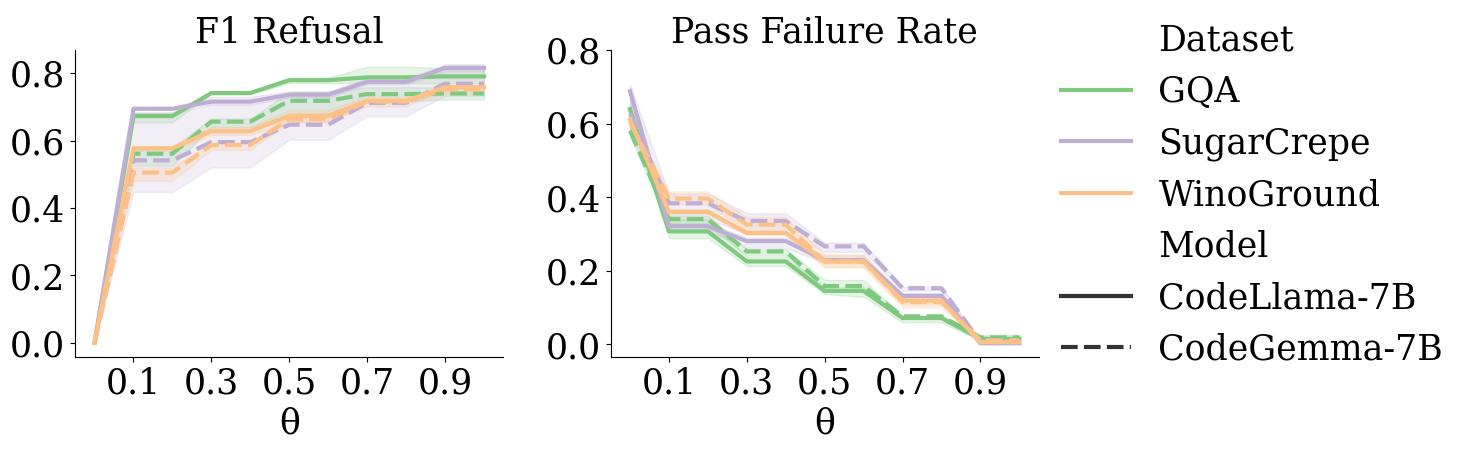

In [55]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 25
plt.rcParams['figure.figsize'] = [10, 5]
df = pd.concat([gqa_refusal_plot, sc_refusal_plot, wg_refusal_plot, cg_gqa_refusal_plot, cg_sc_refusal_plot, cg_wg_refusal_plot])
# df = pd.concat([gqa_refusal_plot, wg_refusal_plot, cg_gqa_refusal_plot, cg_sc_refusal_plot, cg_wg_refusal_plot])

g= sns.relplot(
    data=df,
    x='threshold',
    y='value',
    col='type',
    hue='Dataset',
    style='Model',
    kind='line',
    palette='Accent',
    col_wrap=2,
    aspect=1.2,
    facet_kws={'sharey': False, 'sharex': False},
    linewidth=3
)
g.set_titles('{col_name}')
g.set(xticks=[0.1,0.3,0.5,0.7,0.9])
g.set(yticks=[0.0,0.2,0.4,0.6,0.8])

sns.move_legend(g, "upper left", bbox_to_anchor=(0.73, 0.97), ncol=1, title_fontproperties={'weight':'bold'})
g.set_axis_labels('θ', '')
plot_path = '/nlpgpu/data/artemisp/visual_unit_testing/plots'
plt.savefig(os.path.join(plot_path, 'refusal_plot.pdf'), bbox_inches='tight')

In [56]:
def get_folder_accuracy_with_refusal(folder, fixed_acc, th=0.9, on_error=False):
    acc_fn = GQA_accuracy if 'GQA' in folder else general_accuracy
    postproc_fn = gqa_postproc if 'GQA' in folder else general_postprocessing
    data ={'acc': [], 'run': [], 'passed_percentage': []}
    for s in [1,2,3]: #range(1,1):
        id2ut ={}
        if not os.path.exists(folder.format(s)) or not os.path.exists(os.path.join(folder.format(s), 'data.p')):
            print('Folder {} does not exist'.format(folder.format(i,s)))
            continue
        else:
            gqa_data = pickle.load(open(os.path.join(folder.format(s), 'data.p'), 'rb'))
            # if 'final_accuracy' not in gqa_data[0]:
            #     print('No final_accuracy found in {}'.format(folder.format(i,s)))
            #     continue
            
            if 'id' in gqa_data[0]:
                key = 'id'
            else:
                key = 'sample_id'
            id2acc = {}
            for d in gqa_data:
                if 'unit_test_results' in d:
                    id2ut[d[key]] = unit_test_score_penalyze_error_raw(d['selected_unit_tests'], d['unit_test_results'],0.1,0.1, acc_fn, postproc_fn)
                if (not on_error and 'unit_test_results' in d and id2ut[d[key]]<th) or (on_error and d['code_outputs'][0][0]['error'] is not None):
                    id2acc[d[key]] = fixed_acc[d[key]][s-1]
                else:
                    id2acc[d[key]] = acc_fn([d['code_outputs'][0][0]['output']],[d['answer']]) if d['code_outputs'][0][0]['error'] is None else fixed_acc[d[key]][s-1]
                
            correct = sum(id2acc.values())
            total = len(gqa_data)
            data['passed_percentage'] = sum([int(u > th) for u in id2ut.values()])/len(gqa_data)
            data['acc'].append((correct/total)*100.)
            data['run'].append(s)
    return pd.DataFrame(data)

In [57]:
gqa_ut_codellama_refusal = get_folder_accuracy_with_refusal('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/reprompting/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/1program/run{}/', gqa_fixed_code, th=0.7)
sc_ut_codellama_refusal = get_folder_accuracy_with_refusal('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/reprompting/base_execution_high_temp/1program/run{}/', sc_fixed_code, th=0.7)
wg_ut_codellama_refusal = get_folder_accuracy_with_refusal('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_reprompting/base_execution_high_temp/1program/run{}/', wg_fixed_code, th=0.7)

In [140]:
template = "CodeLlama-7B & 1 & 5 &{}& {}  &{} & {}\\\\"
single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$\pm$" + f"{round(y, 2):.2f}"
acc = gqa_ut_codellama_refusal['acc'].mean()
std = gqa_ut_codellama_refusal['acc'].std()
acc_wg = wg_ut_codellama_refusal['acc'].mean()
std_wg = wg_ut_codellama_refusal['acc'].std()
acc_sc = sc_ut_codellama_refusal['acc'].mean()
std_sc = sc_ut_codellama_refusal['acc'].std()
average = single_template(gqa_ut_codellama_refusal['acc'].mean(), gqa_ut_codellama_refusal['acc'].std())
gqa = single_template(gqa_ut_codellama_refusal['acc'].mean(), gqa_ut_codellama_refusal['acc'].std())
wg = single_template(wg_ut_codellama_refusal['acc'].mean(), wg_ut_codellama_refusal['acc'].std())
sc = single_template(sc_ut_codellama_refusal['acc'].mean(), sc_ut_codellama_refusal['acc'].std())
print(template.format(gqa, wg, sc, average))

CodeLlama-7B & 1 & 5 &54.18$\pm$0.40& 50.67$\pm$1.28  &49.05$\pm$0.82 & 54.18$\pm$0.40\\


In [ ]:
codegemma_gqa_refusal = get_folder_accuracy_with_refusal('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/reprompting/eval_codegemma/virep_split/diffusion_unit_tests_lm_guided_coverage/5_unit_test/1program/run{}/', gqa_fixed_code, th=0.7)
codegemma_sc_refusal = get_folder_accuracy_with_refusal('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/reprompting/base_execution_high_temp/1program/run{}/', sc_fixed_code, th=0.7)
codegemma_wg_refusal = get_folder_accuracy_with_refusal('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval_codegemma/all_reprompting/base_execution_high_temp/1program/run{}/', wg_fixed_code, th=0.7)

In [142]:
template = "CodeGemma-7B & 1 & 5 &{}& {}  &{}&{}\\\\"
single_template =lambda x,y:  f"{round(x, 2):.2f}" + "$\pm$" + f"{round(y, 2):.2f}"
acc = codegemma_gqa_refusal['acc'].mean()
std = codegemma_gqa_refusal['acc'].std()
acc_wg = codegemma_wg_refusal['acc'].mean()
std_wg = codegemma_wg_refusal['acc'].std()
acc_sc = codegemma_sc_refusal['acc'].mean()
std_sc = codegemma_sc_refusal['acc'].std()
average = single_template(codegemma_gqa_refusal['acc'].mean(), codegemma_gqa_refusal['acc'].std())
gqa = single_template(codegemma_gqa_refusal['acc'].mean(), codegemma_gqa_refusal['acc'].std())
wg = single_template(codegemma_wg_refusal['acc'].mean(), codegemma_wg_refusal['acc'].std())
sc = single_template(codegemma_sc_refusal['acc'].mean(), codegemma_sc_refusal['acc'].std())
print(template.format(gqa, wg, sc, average))

CodeGemma-7B & 1 & 5 &54.58$\pm$1.24& 50.73$\pm$0.94  &50.12$\pm$1.62&54.58$\pm$1.24\\


In [ ]:
codegemma_gqa_refusal_on_error = get_folder_accuracy_with_refusal('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/reprompting/eval_codegemma/virep_split/diffusion_unit_tests_lm_guided_coverage/5_unit_test/1program/run{}/', gqa_fixed_code, th=0.8, on_error=True)
codegemma_sc_refusal_on_error = get_folder_accuracy_with_refusal('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/reprompting/base_execution_high_temp/1program/run{}/', sc_fixed_code, th=0.8, on_error=True)
codegemma_wg_refusal_on_error = get_folder_accuracy_with_refusal('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval_codegemma/all_reprompting/base_execution_high_temp/1program/run{}/', wg_fixed_code, th=0.8, on_error=True)

In [144]:
template = "CodeGemma-7B & 1 & 5 &{}& {}  &{} &{}\\\\"
single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$\pm$" + f"{round(y, 2):.2f}"
acc = codegemma_gqa_refusal_on_error['acc'].mean()
std = codegemma_gqa_refusal_on_error['acc'].std()
acc_wg = codegemma_wg_refusal_on_error['acc'].mean()
std_wg = codegemma_wg_refusal_on_error['acc'].std()
acc_sc = codegemma_sc_refusal_on_error['acc'].mean()
std_sc = codegemma_sc_refusal_on_error['acc'].std()
average = single_template(codegemma_gqa_refusal_on_error['acc'].mean(), codegemma_gqa_refusal_on_error['acc'].std())
gqa = single_template(codegemma_gqa_refusal_on_error['acc'].mean(), codegemma_gqa_refusal_on_error['acc'].std())
wg = single_template(codegemma_wg_refusal_on_error['acc'].mean(), codegemma_wg_refusal_on_error['acc'].std())
sc = single_template(codegemma_sc_refusal_on_error['acc'].mean(), codegemma_sc_refusal_on_error['acc'].std())
print(template.format(gqa, wg, sc, average))

CodeGemma-7B & 1 & 5 &44.89$\pm$2.19& 47.25$\pm$2.17  &49.58$\pm$0.88 &44.89$\pm$2.19\\


In [63]:
codellama_gqa_refusal_on_error = get_folder_accuracy_with_refusal('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/reprompting/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/1program/run{}/', gqa_fixed_code, th=0.7, on_error=True)
codellama_sc_refusal_on_error = get_folder_accuracy_with_refusal('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/reprompting/base_execution_high_temp/1program/run{}/', sc_fixed_code, th=0.7, on_error=True)
codellama_wg_refusal_on_error = get_folder_accuracy_with_refusal('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_reprompting/base_execution_high_temp/1program/run{}/', wg_fixed_code, th=0.7, on_error=True)


In [146]:
template = "CodeLlama-7B & 1 & 5 &{}& {}  &{} & {}\\\\"
single_template = lambda x,y:  f"{round(x, 2):.2f}" + "$\pm$" + f"{round(y, 2):.2f}"
acc = codellama_gqa_refusal_on_error['acc'].mean()
std = codellama_gqa_refusal_on_error['acc'].std()
acc_wg = codellama_wg_refusal_on_error['acc'].mean()
std_wg = codellama_wg_refusal_on_error['acc'].std()
acc_sc = codellama_sc_refusal_on_error['acc'].mean()
std_sc = codellama_sc_refusal_on_error['acc'].std()
sc = single_template(codellama_sc_refusal_on_error['acc'].mean(), codellama_sc_refusal_on_error['acc'].std())
gqa = single_template(codellama_gqa_refusal_on_error['acc'].mean(), codellama_gqa_refusal_on_error['acc'].std())
wg = single_template(codellama_wg_refusal_on_error['acc'].mean(), codellama_wg_refusal_on_error['acc'].std())
average = single_template(codellama_gqa_refusal_on_error['acc'].mean(), codellama_gqa_refusal_on_error['acc'].std()) 
print(template.format(gqa, wg, sc, average))     

CodeLlama-7B & 1 & 5 &44.89$\pm$2.04& 51.67$\pm$1.16  &49.29$\pm$0.99 & 44.89$\pm$2.04\\


# Type Analysis

## Unit Test Improvement

In [67]:
def get_improvements(folder, folder_base):
    acc_fn = GQA_accuracy if 'GQA' in folder else general_accuracy
    _, folder_scores = get_folder_scores(folder, compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1)
    print(folder_scores.keys())
    _, folder_base_scores = get_base_scores(folder_base, compute='max_count')
    print(folder_base_scores.keys())
    program2group2improv = defaultdict(dict)
    for i in [5]:
        for s in [1,2,3]:
            curr_folder = folder.format(i,s) 
            curr_folder_base = folder_base.format(s)
            data = pickle.load(open(curr_folder+'/data.p', 'rb')) 
            key = 'id' if 'id' in data[0] else 'sample_id'
            group_key = 'group' if 'group' in data[0] else 'question_type'
            key2group = {d[key]: d[group_key] for d in data}
            curr_folder_scores = folder_scores[curr_folder]
            curr_folder_base_scores = folder_base_scores[curr_folder_base]
            group2acc = defaultdict(list)
            group2acc_base = defaultdict(list)
            for d,v in curr_folder_scores.items():
                group = key2group[d]
                group2acc[group].append(v)
                group2acc_base[group].append(curr_folder_base_scores[d])
            improvement = {}
            for g in group2acc:
                improvement[g] = np.mean(group2acc[g]) - np.mean(group2acc_base[g])
            program2group2improv[i][s] = improvement
    # means across runs
    program2group2improv_means = {}
    for i in program2group2improv:
        program2group2improv_means[i] = {}
        for g in program2group2improv[i][1]:
            program2group2improv_means[i][g] = np.mean([program2group2improv[i][s][g] for s in [1,2,3]])
    #stds across runs
    program2group2improv_stds = {}
    for i in program2group2improv:
        program2group2improv_stds[i] = {}
        for g in program2group2improv[i][1]:
            program2group2improv_stds[i][g] = np.std([program2group2improv[i][s][g] for s in [1,2,3]])
    return program2group2improv_means, program2group2improv_stds
            
            
                
                
                
        

In [68]:
gqa_improvements_mean, gqa_improvements_std = get_improvements('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/{}program/run{}', '/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/base_execution/1program/run{}/')

UnboundLocalError: local variable 'id2acc' referenced before assignment

In [ ]:
sc_improvements_cg_mean, sc_improvements_cg_std = get_improvements('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/stable_diffusion_unit_tests_lm_guided/5_unit_test/{}program/run{}', '/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/base_execution_high_temp/1program/run{}/')

In [ ]:
sorted(sc_improvements_cg_mean[5].items(), key=lambda x: x[1], reverse=True)

In [ ]:
sorted(gqa_improvements_mean[5].items(), key=lambda x: x[1], reverse=True)

In [ ]:
gqa_folder_scores = get_folder_scores('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/{}program/run{}', compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1)

In [ ]:
gqa_base_folder_scores = get_base_scores('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/base_execution/1program/run{}/', compute='first_non_error')

In [ ]:
scores = gqa_folder_scores[1]['/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/2program/run1']

In [ ]:
data = pickle.load(open('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/2program/run1/data.p', 'rb'))

In [ ]:
data2type = {d['sample_id']: d['group'] for d in data}    

In [ ]:
group2acc = {}
group2total = {}
for k,v in scores.items():
    if data2type[k] not in group2acc:
        group2acc[data2type[k]] = 0
        group2total[data2type[k]] = 0
    group2acc[data2type[k]] += v
    group2total[data2type[k]] += 1


In [ ]:
group2acc = {k: v/group2total[k] for k,v in group2acc.items()}

In [ ]:
group2acc

In [ ]:
group2acc_base = {}
group2total_base = {}
for f,id2acc in gqa_base_folder_scores[1].items():
    if '1program' not in f:
        continue
    for k,v in id2acc.items():
        if data2type[k] not in group2acc_base:
            group2acc_base[data2type[k]] = 0
            group2total_base[data2type[k]] = 0
        group2acc_base[data2type[k]] += v
        group2total_base[data2type[k]] += 1
    group2acc_base = {k: v/group2total_base[k] for k,v in group2acc_base.items()}
    break

In [ ]:
group2acc_base

In [ ]:
group2diff = {k: group2acc[k] - group2acc_base[k] for k in group2acc}

In [ ]:
sorted(group2diff.items(), key=lambda x: x[1])

In [ ]:
for d in data:
    if d['group'] == 'how':
        print(d['question'])